# Импорт модулей

In [466]:
from tqdm import tqdm
from datetime import datetime
import json5 as json
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from haversine import haversine
from pykrige.ok import OrdinaryKriging
from sklearn.neighbors import BallTree

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

In [ ]:
pd.options.mode.chained_assignment = None

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)

# Загрузка данных

In [523]:
directory_hist = 'track_2_package/'
directory_extra = ['2_track_cp1/', '2_track_cp2/', '2_track_cp3/', '2_track_cp4/']

In [524]:
# выгрузим в DTYPES названия полей и соответствующие им типы данных

with open('dtypes.json', 'r') as f:
    DTYPES = json.load(f)

In [525]:
# исторические данные

custom_date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

train_hist = pd.read_csv(directory_hist + 'train.csv',
#                          dtype=DTYPES['train'],
                         parse_dates=['date'], date_parser=custom_date_parser)

# meteo_3hours_hist = pd.read_csv(directory_hist + 'meteo_3hours.csv',
#                                 dtype=DTYPES['meteo_3hours'],
#                                 parse_dates=['date_local'], date_parser=custom_date_parser)

meteo_1day_hist = pd.read_csv(directory_hist + 'meteo_1day.csv',
#                               dtype=DTYPES['meteo_1day'],
                              parse_dates=['date'], date_parser=custom_date_parser)

meteo_1month_hist = pd.read_csv(directory_hist + 'meteo_1month.csv',
#                                 dtype=DTYPES['meteo_1month'],
                                parse_dates=['date'], date_parser=custom_date_parser)

hydro_coord = pd.read_csv(directory_hist + 'hydro_coord.csv', dtype=DTYPES['hydro_coord'])
meteo_coord = pd.read_csv(directory_hist + 'meteo_coord.csv', dtype=DTYPES['meteo_coord'])

reference_water_codes = pd.read_csv(directory_hist + 'reference_water_codes.csv', dtype=DTYPES['reference_water_codes'])
reference_horiz_visib = pd.read_csv(directory_hist + 'reference_horiz_visib.csv', dtype=DTYPES['reference_horiz_visib'])

ice_saw = pd.read_csv(directory_hist + 'ice_saw.csv',
                      dtype=DTYPES['ice_saw'],
                      parse_dates=['date'], date_parser=custom_date_parser)

In [526]:
# дополнительные исторические данные

for de in directory_extra:  
    extra_train = pd.read_csv(de + 'extra_train.csv',
#                               dtype=DTYPES['train'],
                              parse_dates=['date'], date_parser=custom_date_parser)
    train_hist = pd.concat([train_hist, extra_train])

# extra_meteo_3hours = pd.read_csv(directory_extra + 'extra_meteo_3hours.csv',
#                                  dtype=DTYPES['meteo_3hours'],
#                                  parse_dates=['date_local'], date_parser=custom_date_parser)

for de in directory_extra:  
    extra_meteo_1day = pd.read_csv(de + 'extra_meteo_1day.csv',
#                                dtype=DTYPES['meteo_1day'],
                                   parse_dates=['date'], date_parser=custom_date_parser)
    meteo_1day_hist = pd.concat([meteo_1day_hist, extra_meteo_1day])

for de in directory_extra:  
    extra_meteo_1month = pd.read_csv(de + 'extra_meteo_1month.csv',
#                                  dtype=DTYPES['meteo_1month'],
                                     parse_dates=['date'], date_parser=custom_date_parser)
    meteo_1month_hist = pd.concat([meteo_1month_hist, extra_meteo_1month])

In [527]:
# данные на тестовый период

test = pd.read_csv(directory_extra[-1] + 'test.csv',
#                    dtype=DTYPES['test'],
                   parse_dates=['date'], date_parser=custom_date_parser)

# forecast_meteo_3hours = pd.read_csv(directory_extra + 'forecast_meteo_3hours.csv',
#                                     dtype=DTYPES['meteo_3hours'],
#                                     parse_dates=['date_local'], date_parser=custom_date_parser)

In [528]:
target_posts = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3050, 3230]

# Заполнение значений за каждый день и пропусков

In [529]:
def fill_everyday(data, start, end):
    
    df = pd.DataFrame()
    
    dates = []
    temp_date = pd.to_datetime(start)

    while temp_date <= pd.to_datetime(end):
        dates.append(temp_date)
        temp_date += datetime.timedelta(days=1)
    
    df['date'] = dates
    df = pd.merge(df, data, on='date', how='left')
    df['station_id'] = data['station_id'].iloc[0]
    return df

train_hist_filled = pd.DataFrame()

for station in tqdm(train_hist.station_id.unique()):
    train_hist_filled = pd.concat([
                                   train_hist_filled,
                                   fill_everyday(train_hist[train_hist.station_id == station], '1985-01-01', '2019-12-31')
                                  ])

train_hist = train_hist_filled.reset_index(drop=True).copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:40<00:00,  1.49s/it]


In [530]:
train_hist['day'] = train_hist.date.apply(lambda x: x.day)
train_hist['month'] = train_hist.date.apply(lambda x: x.month)
train_hist['year'] = train_hist.date.apply(lambda x: x.year)

In [531]:
target_posts = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3050, 3230]

In [532]:
# train_hist.stage_max.interpolate(method='ffill', inplace=True)

In [533]:
# train_hist.delta_stage_max.interpolate(method='ffill', inplace=True)

In [534]:
# train_hist.delta_stage_max.iloc[0] = 0

In [535]:
train_hist = train_hist[train_hist.station_id != 3048]

# Графики уровня воды

In [536]:
def plot_features(data, features, start, end, normalize=True):
    
    df = data[(data.date >= start)&(data.date <= end)].copy()

    fig, ax = plt.subplots(figsize=(20, 6))
    legend = []
    
    for column in features:
        df[column] = df[column] / df[column].max()
        ax.plot(df.date, df.val,
                color='#1B0E61', linewidth=4)
        legend.append(column)
    ax.grid()
    ax.legend(legend)
    ax.set(xlabel='Date',
           ylabel='Value')
    plt.show()

In [537]:
def plot_stage(data, posts, start, end):

    df = data[(data.date >= start)&(data.date <= end)].copy()
    
    fig, ax = plt.subplots(figsize=(20, 6))
    legend = []
    
    for post in posts:
        ax.plot(df[df.station_id == post].date.values, 
                df[df.station_id == post].stage_max.values,
#                 color='#1B0E61', 
                linewidth=2)
        legend.append('stage_max_{}'.format(post))
        
    ax.grid()
    ax.legend(legend)
    ax.set(xlabel='Date',
           ylabel='Value',
           title='Posts: ' + str(' '.join(str(e) for e in posts)))
    plt.show()

In [538]:
def plot_delta_stage_max(data, posts, start, end):

    df = data[(data.date >= start)&(data.date <= end)].copy()
    
    fig, ax = plt.subplots(figsize=(20, 6))
    legend = []
    
    for post in posts:
        ax.plot(df[df.station_id == post].date.values, 
                df[df.station_id == post].delta_stage_max.values,
#                 color='#1B0E61', 
                linewidth=2)
        legend.append('delta_stage_max_{}'.format(post))
        
    ax.grid()
    ax.legend(legend)
    ax.set(xlabel='Date',
           ylabel='Value',
           title='Posts: ' + str(' '.join(str(e) for e in posts)))
    plt.show()

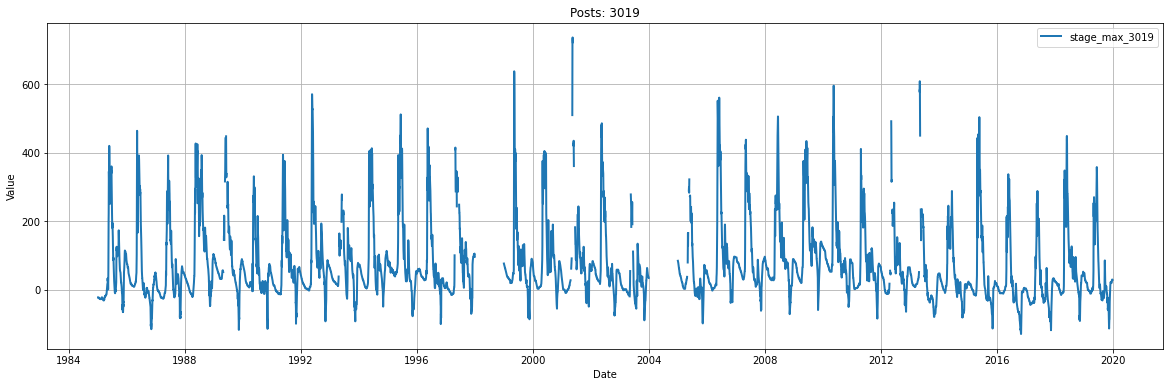

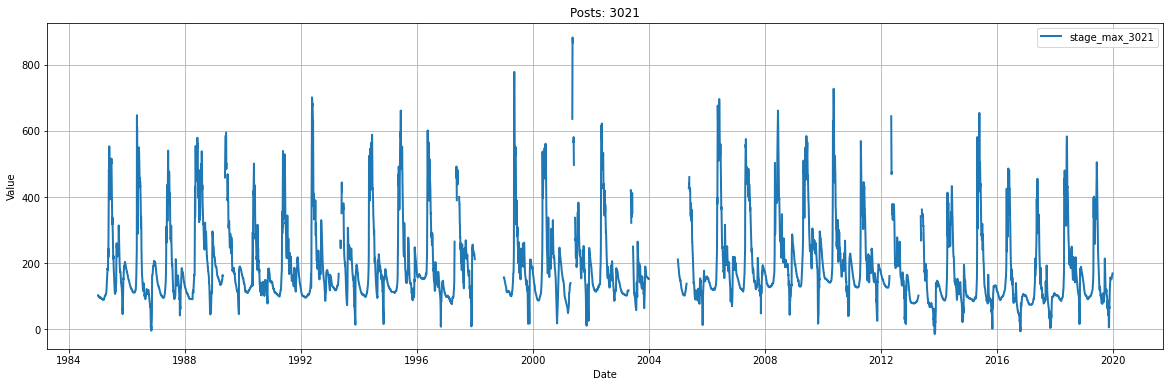

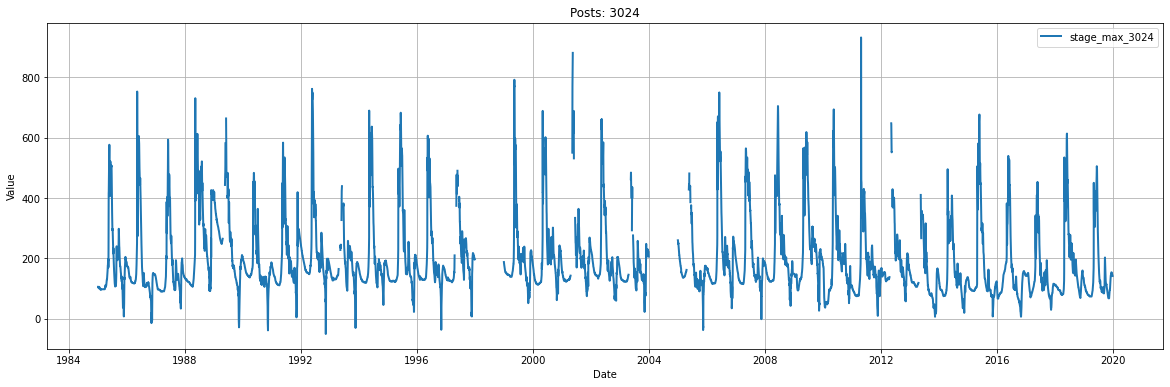

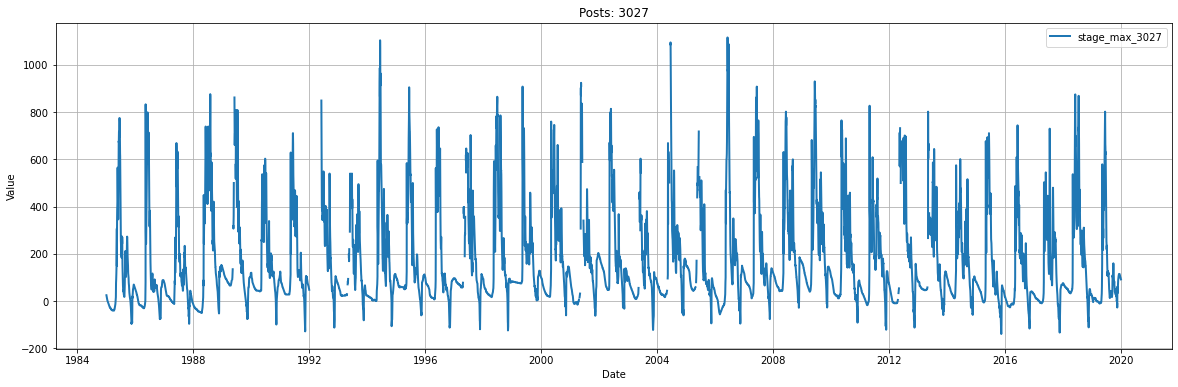

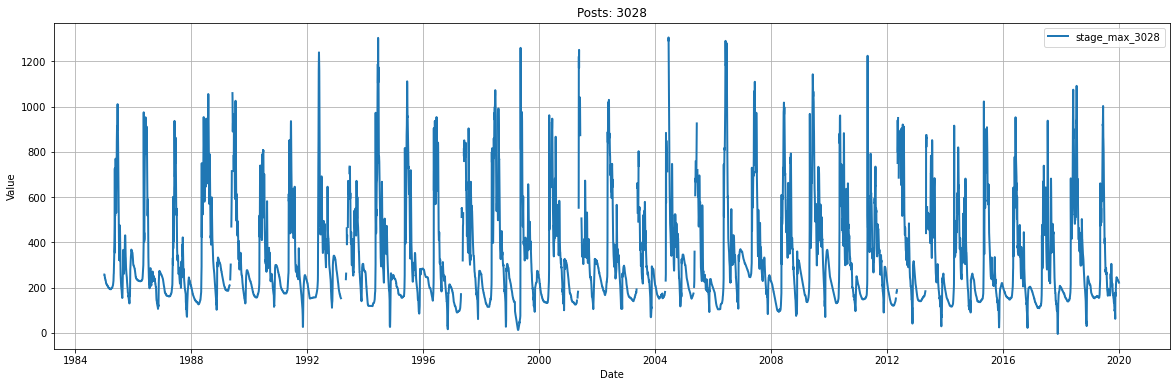

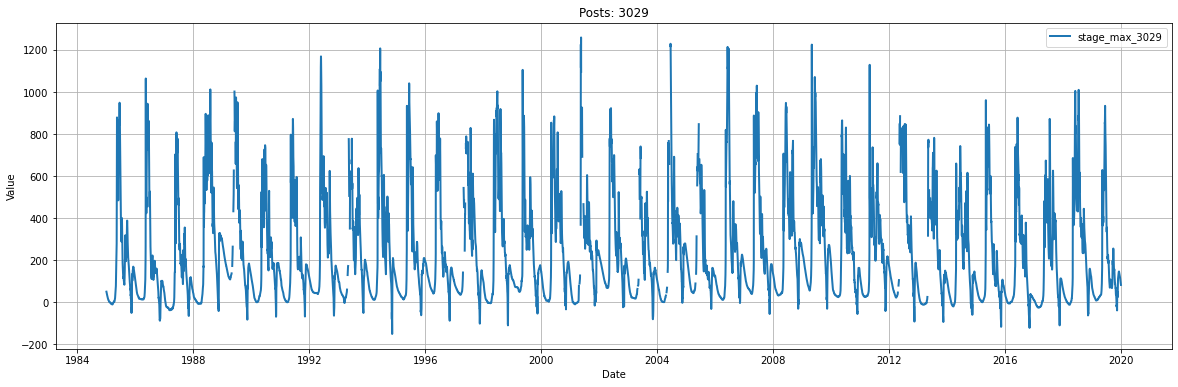

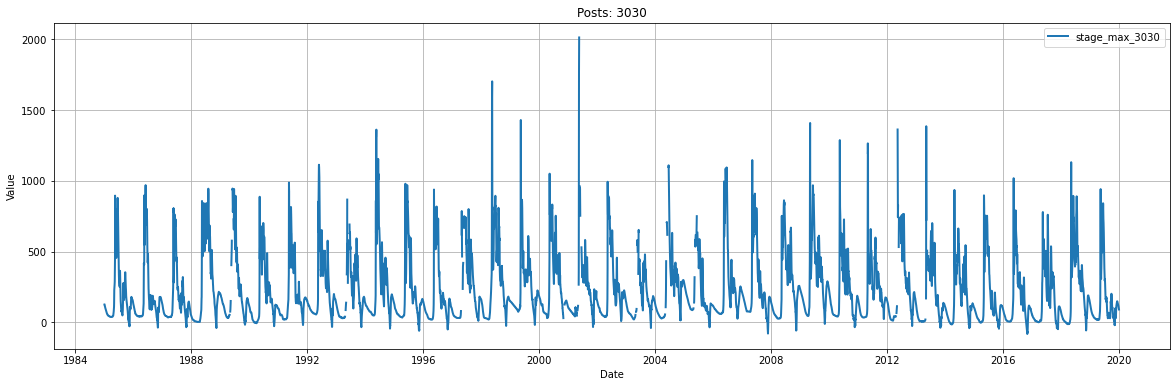

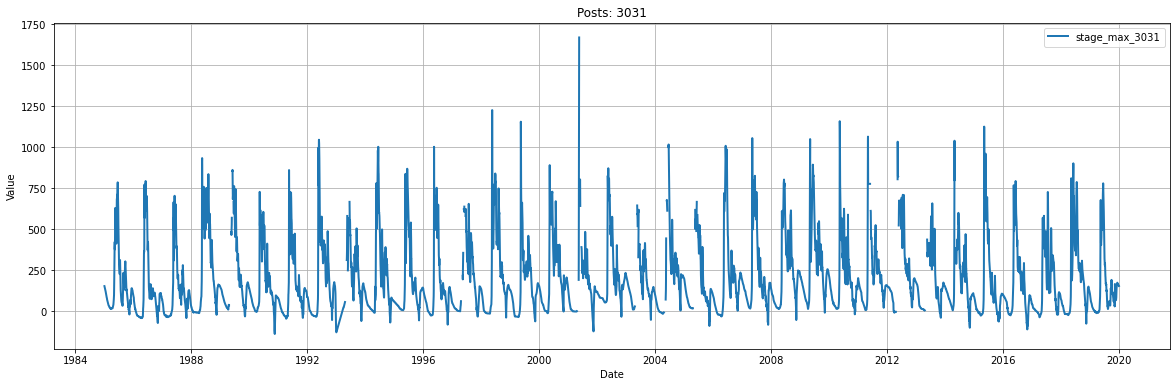

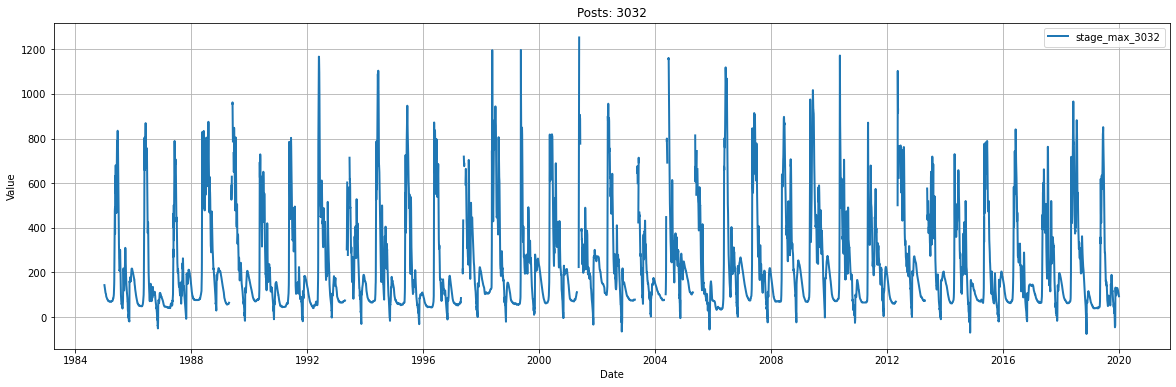

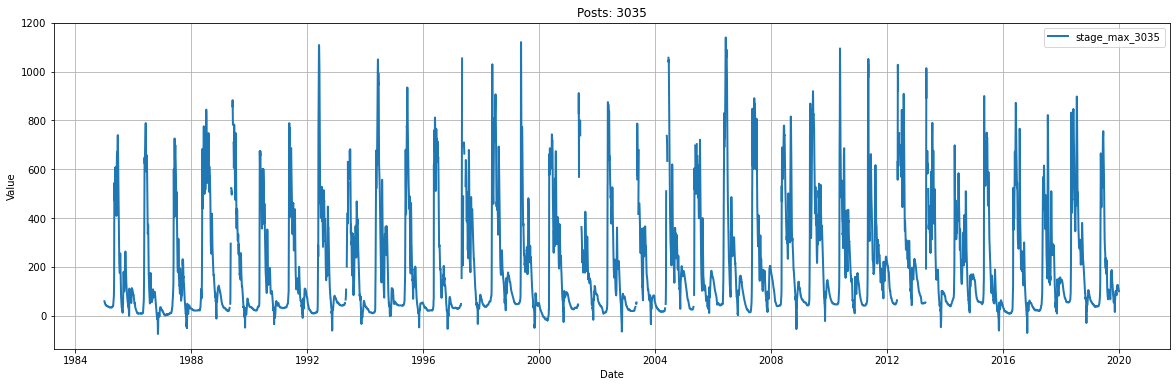

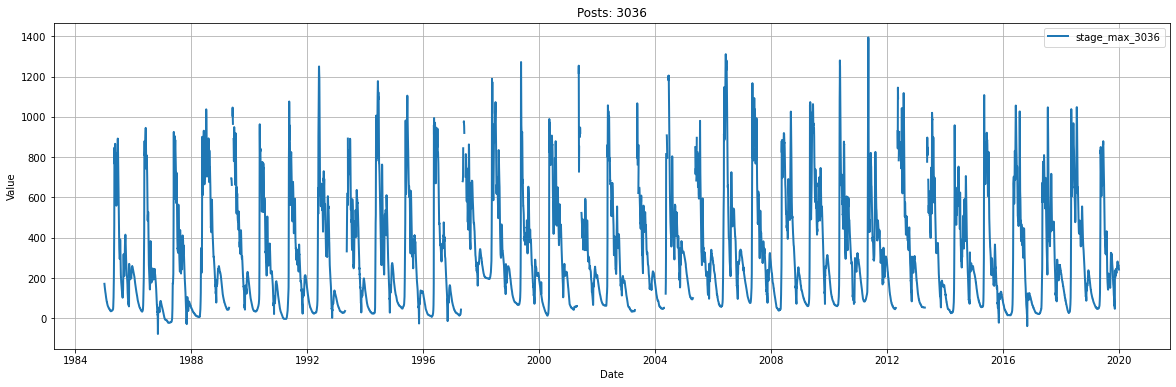

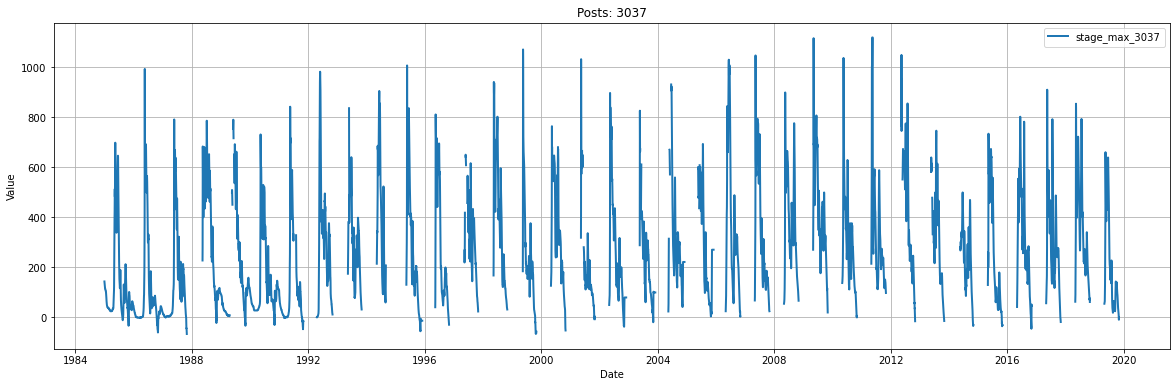

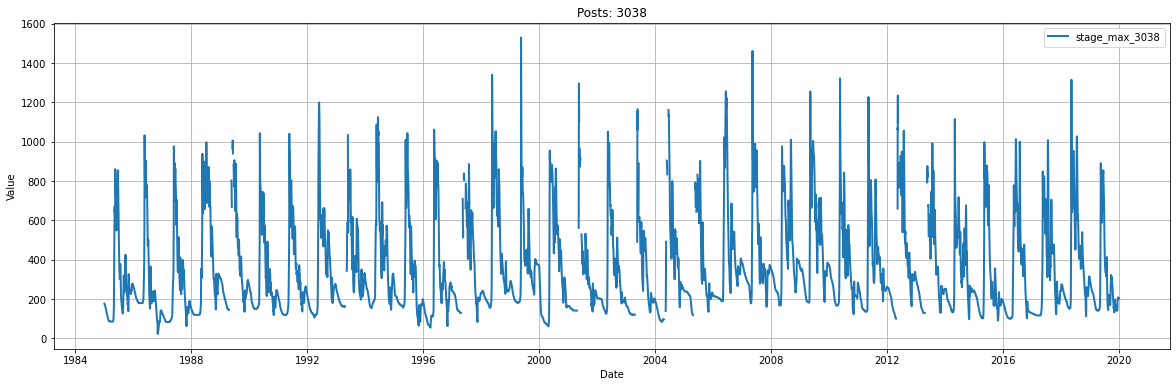

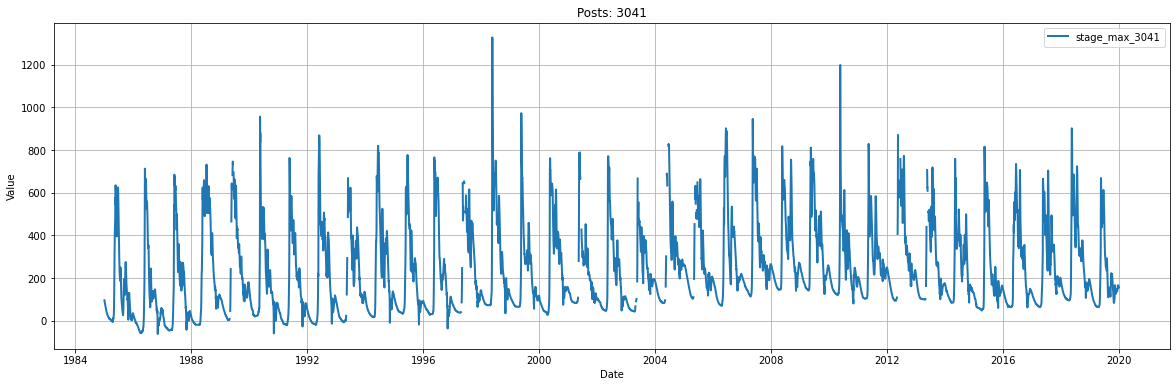

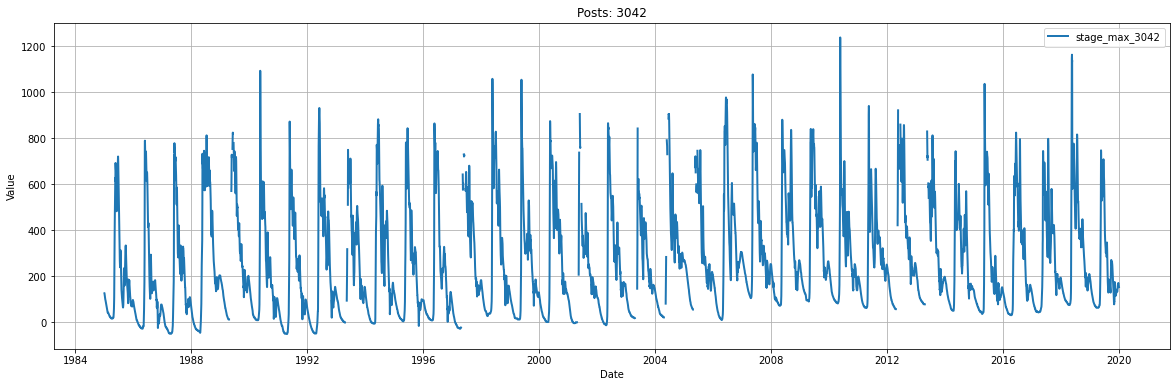

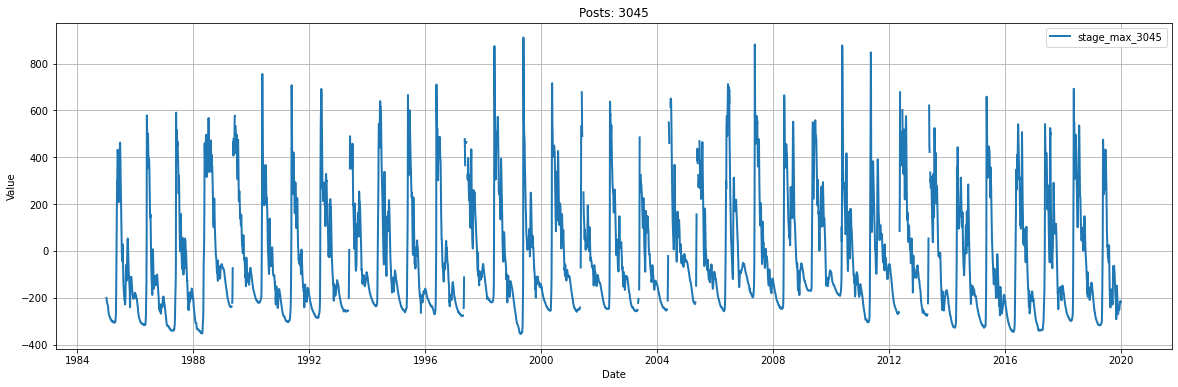

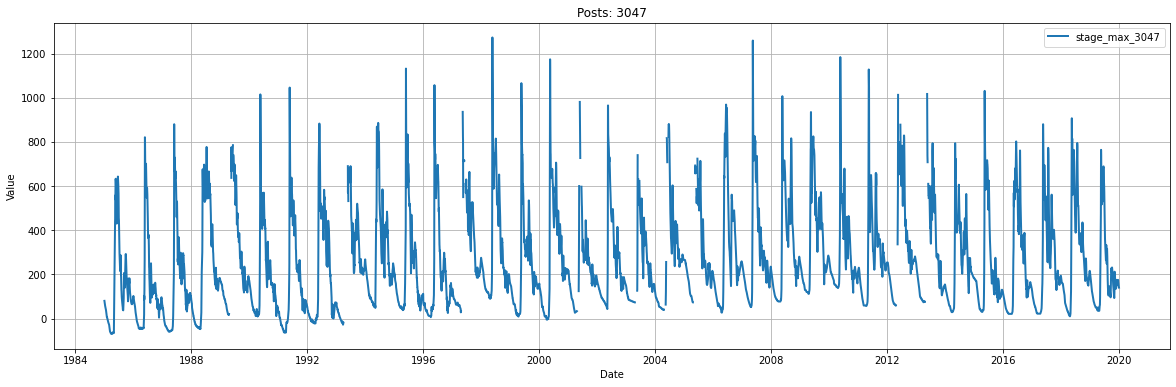

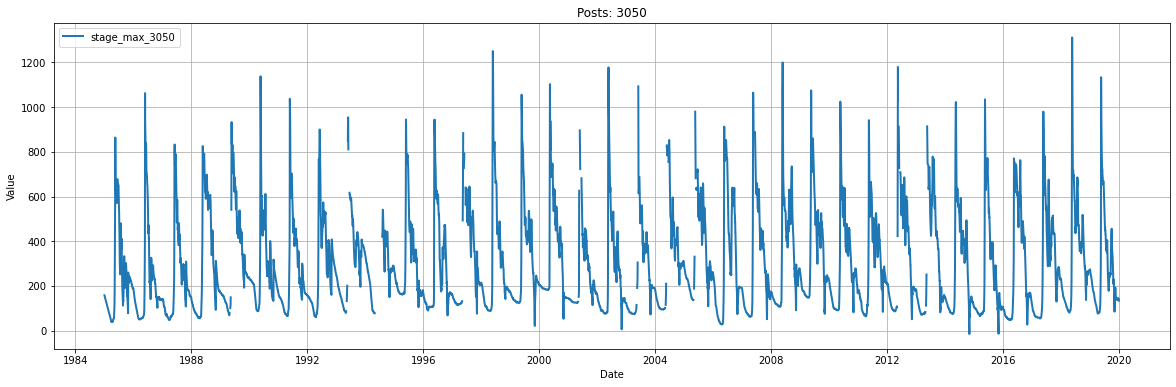

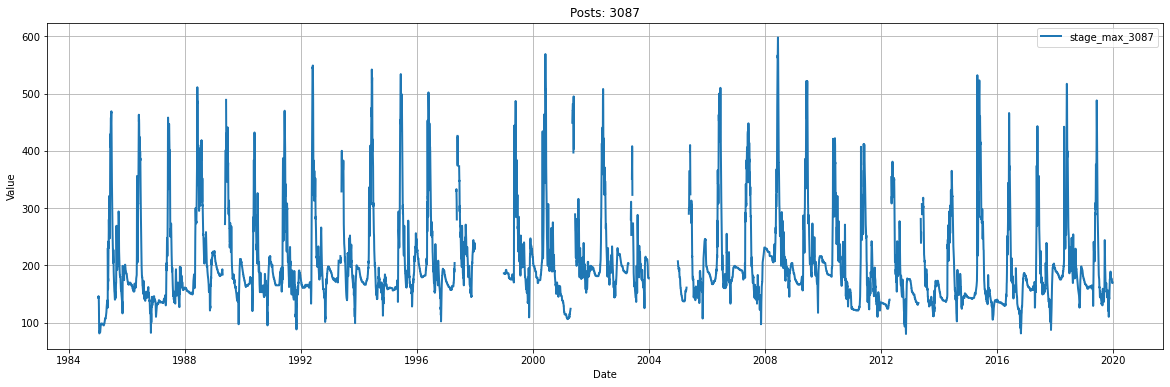

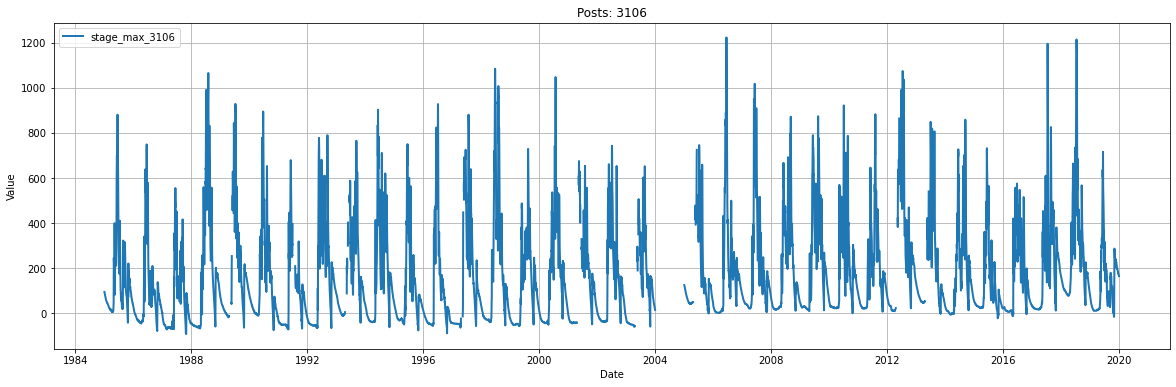

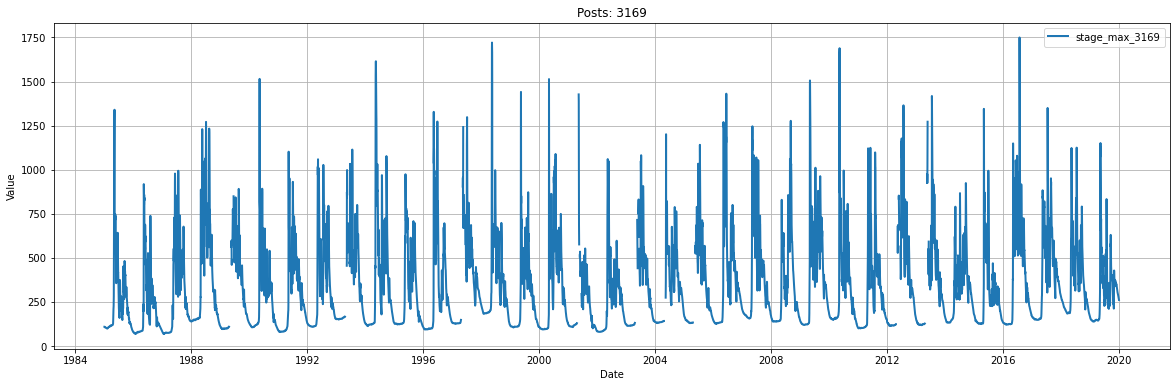

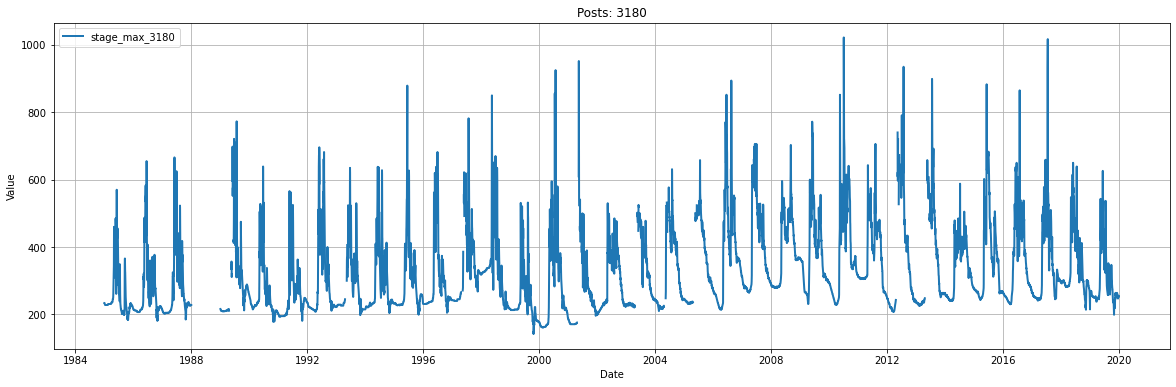

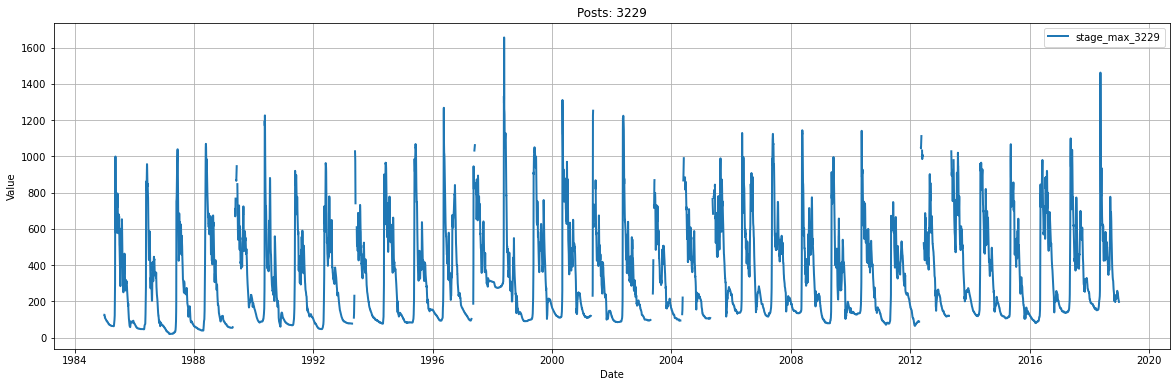

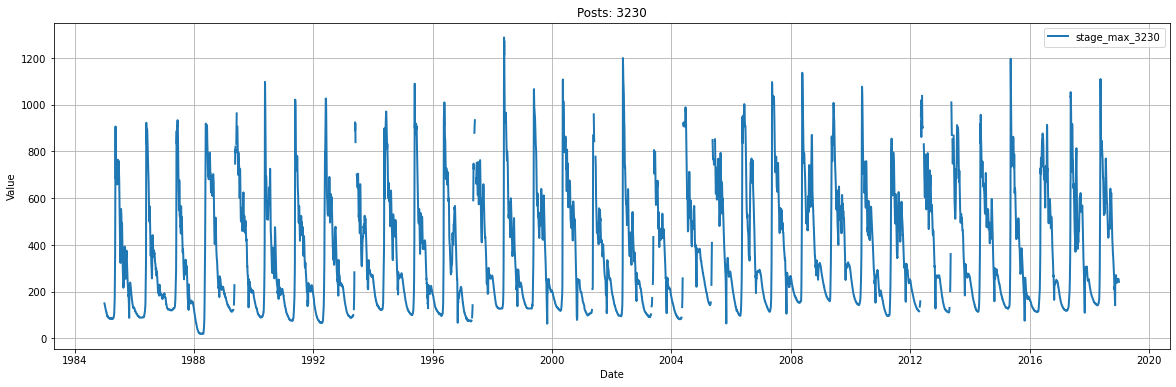

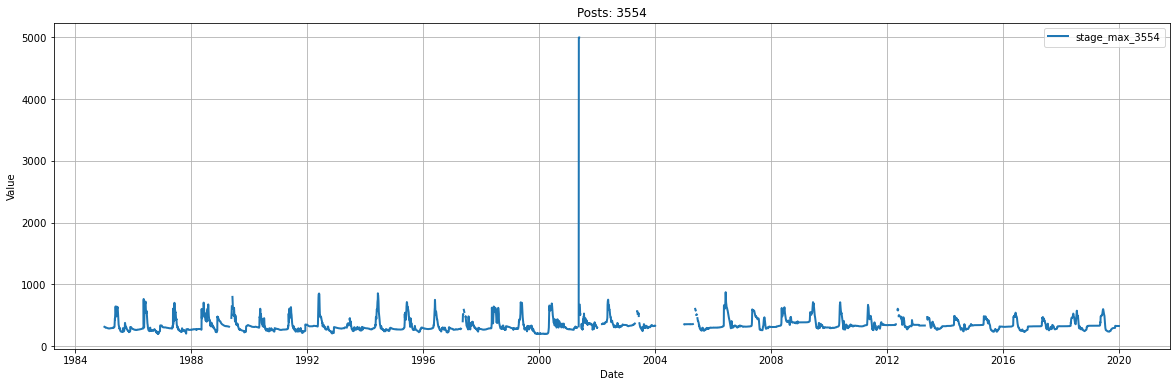

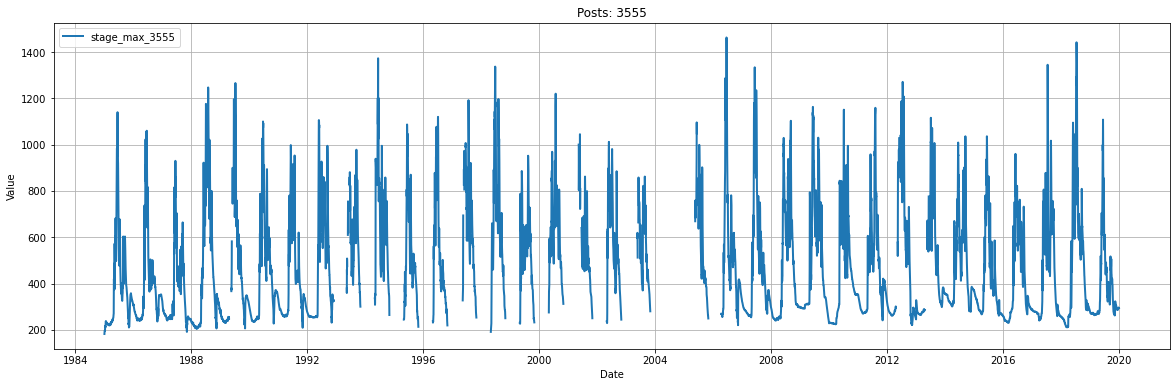

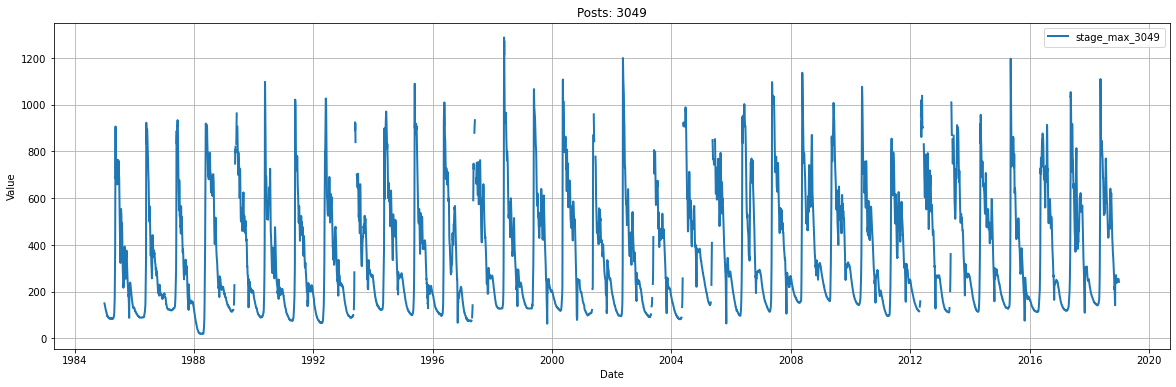

In [620]:
for station in train_hist.station_id.unique():
    plot_stage(train_hist, [station], '1985-01-01', '2019-12-31')

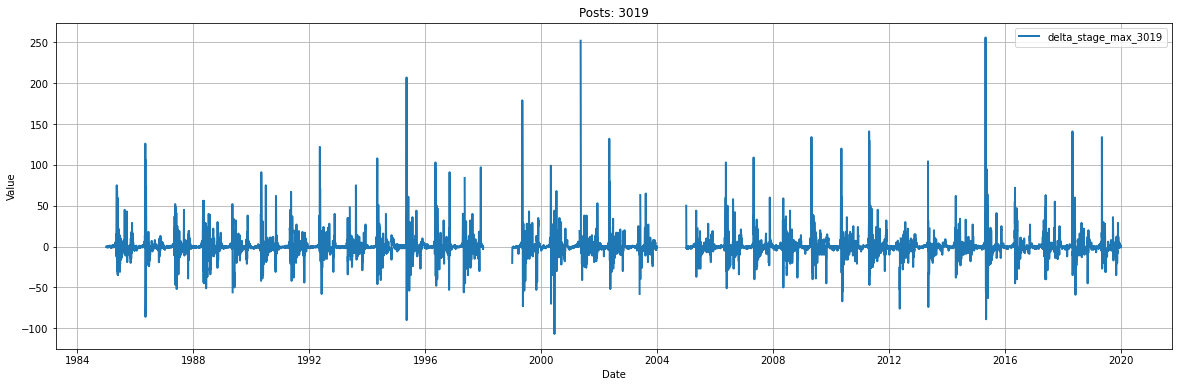

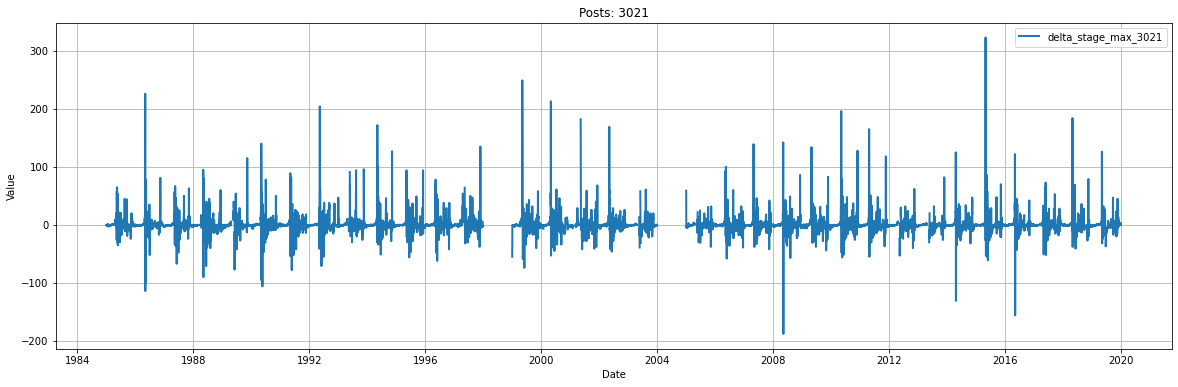

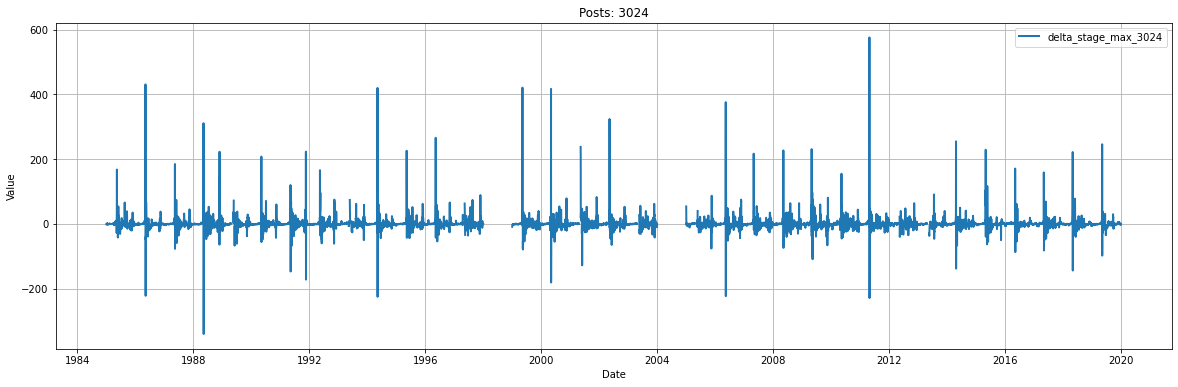

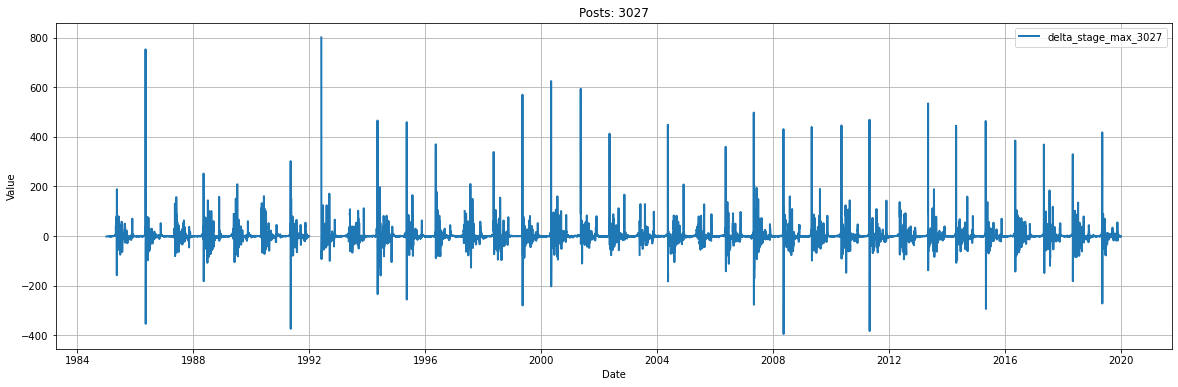

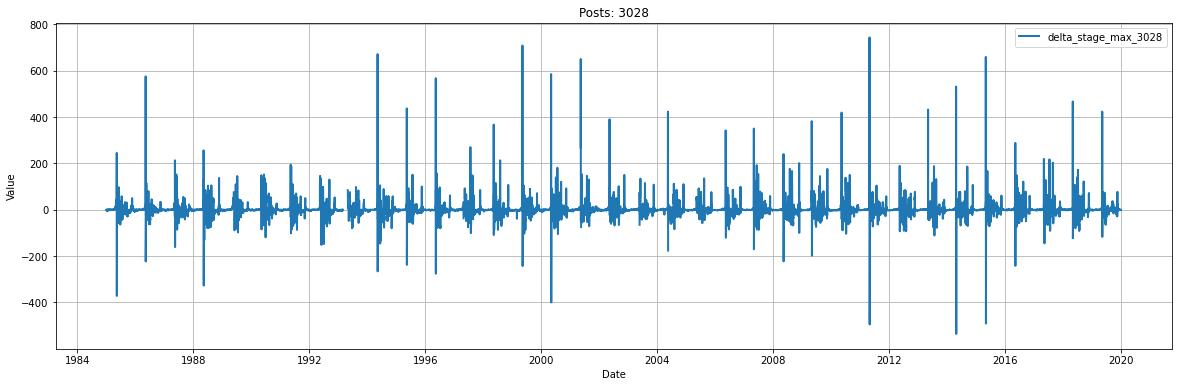

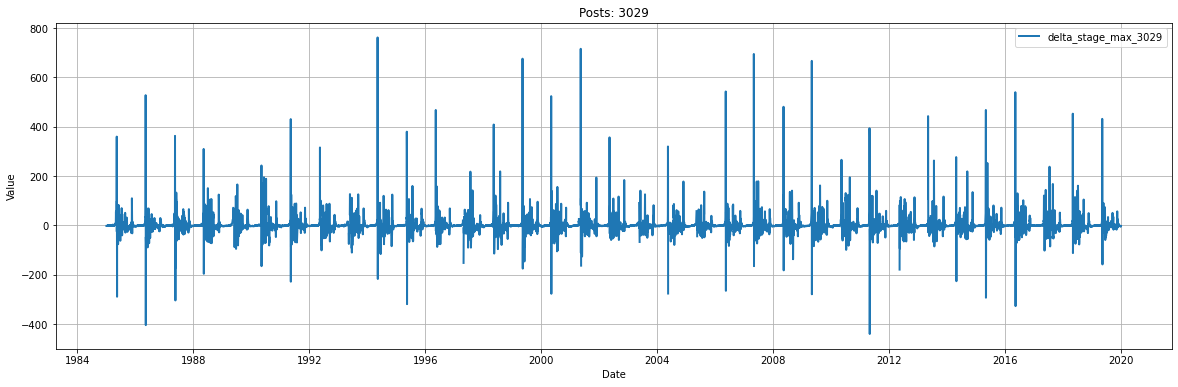

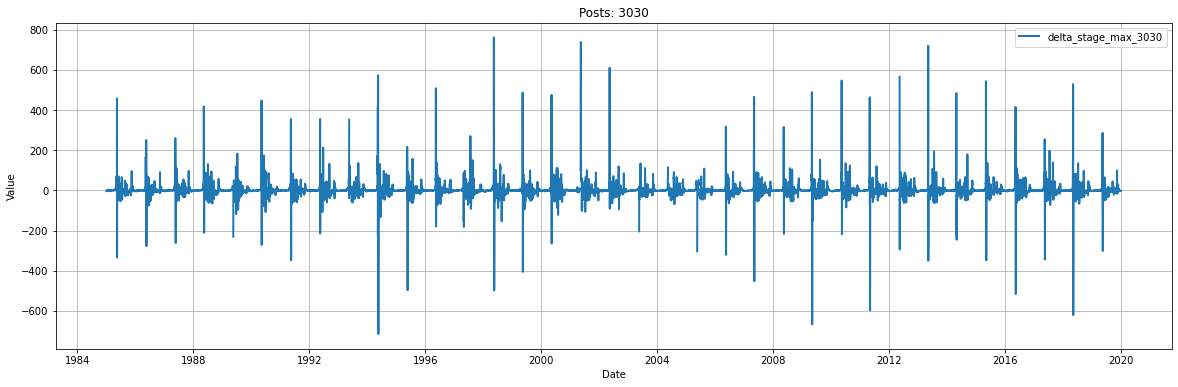

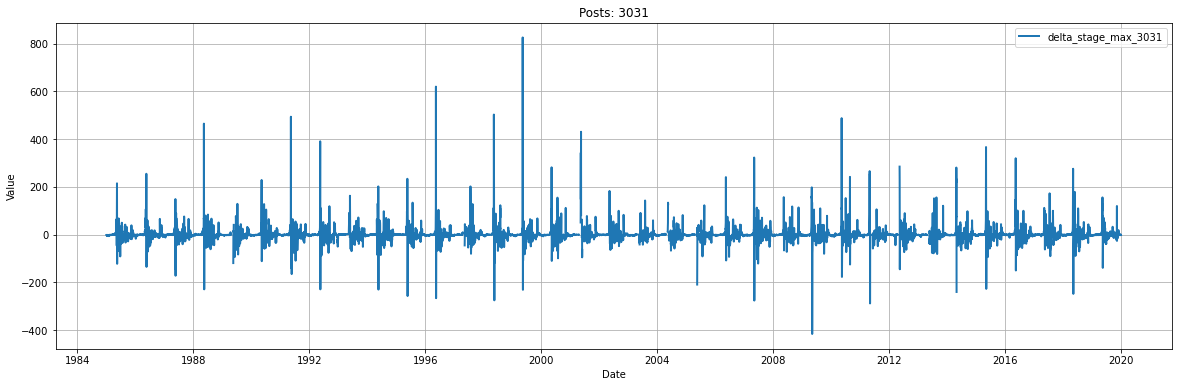

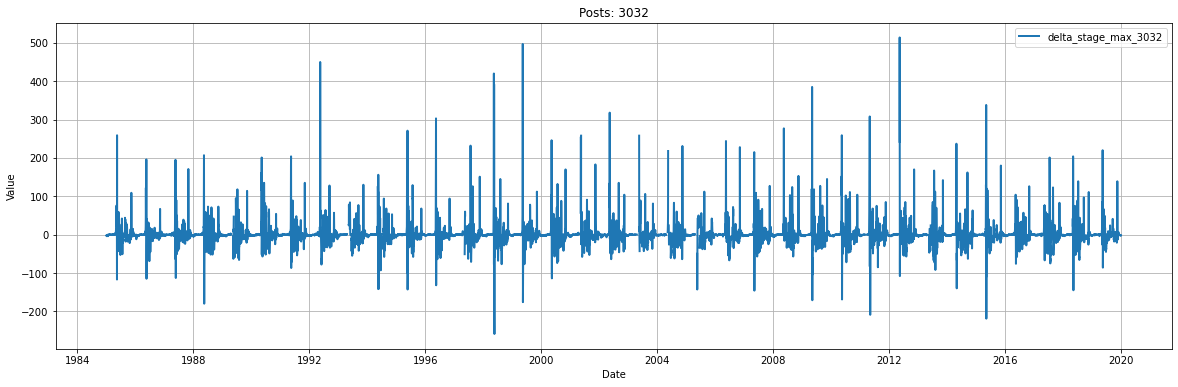

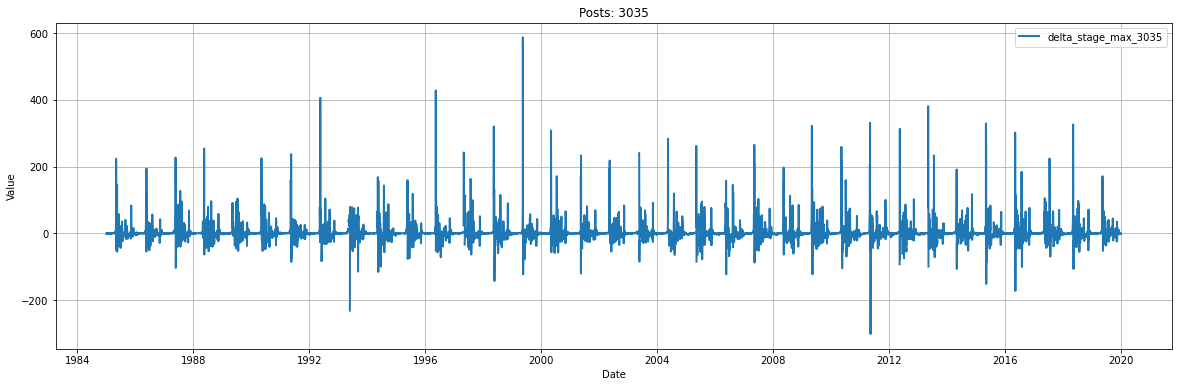

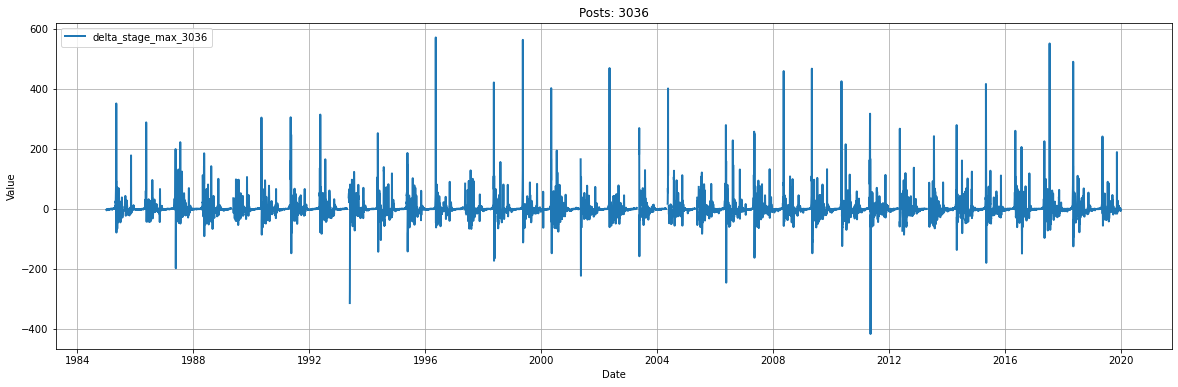

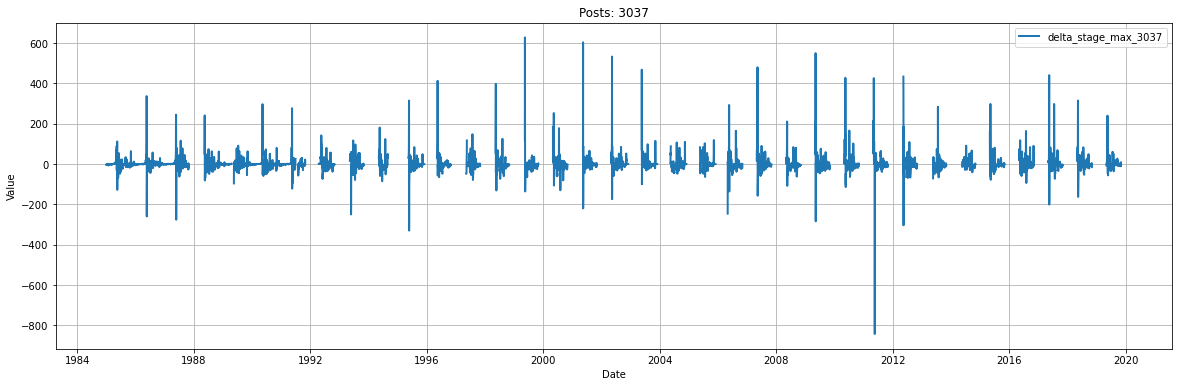

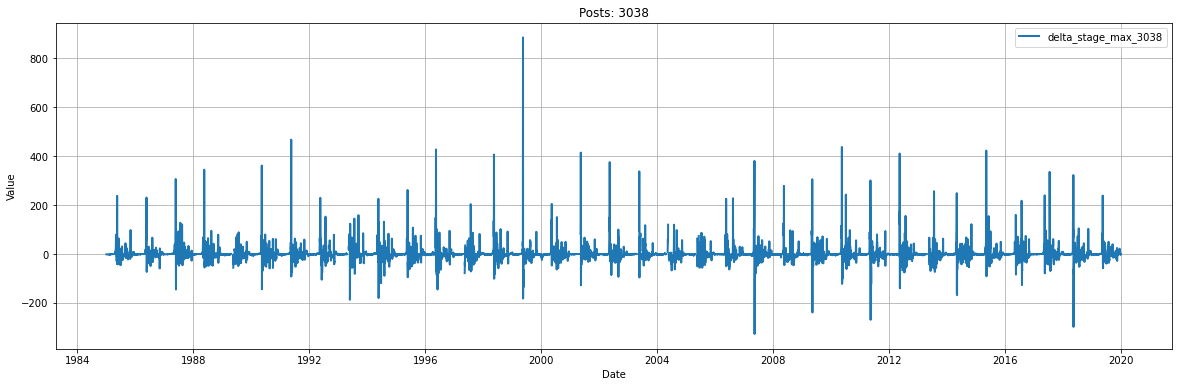

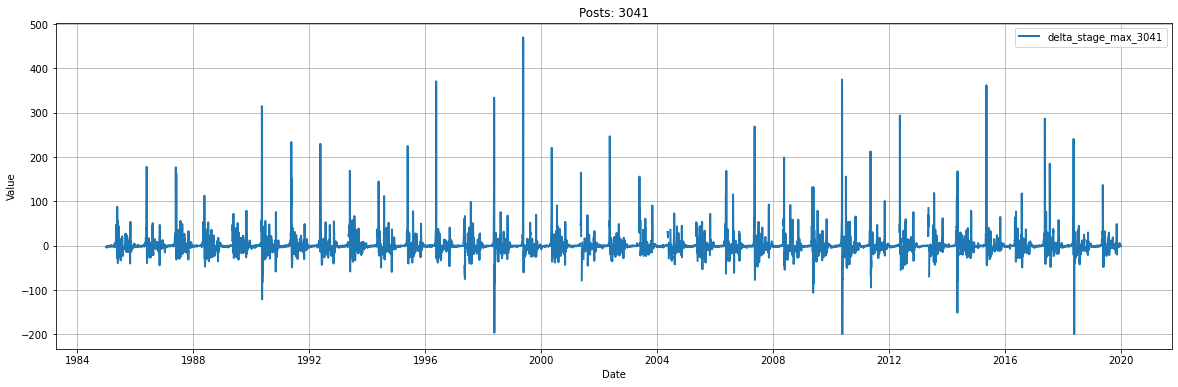

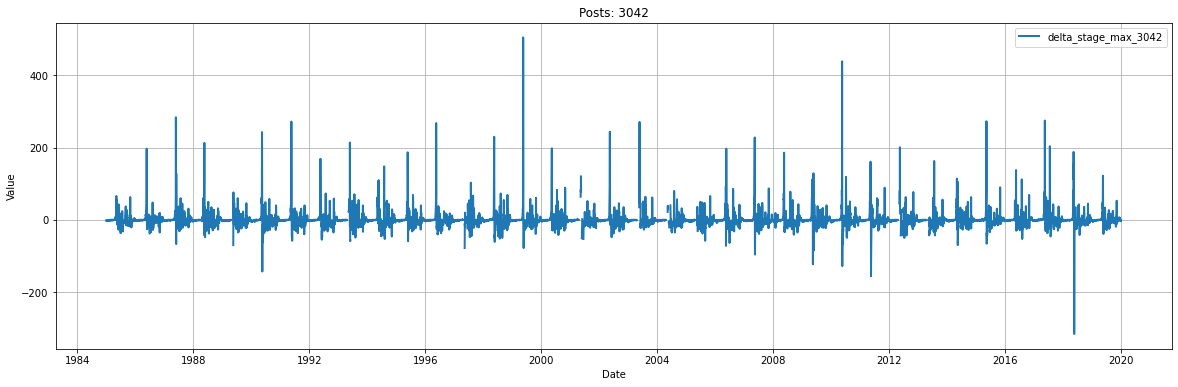

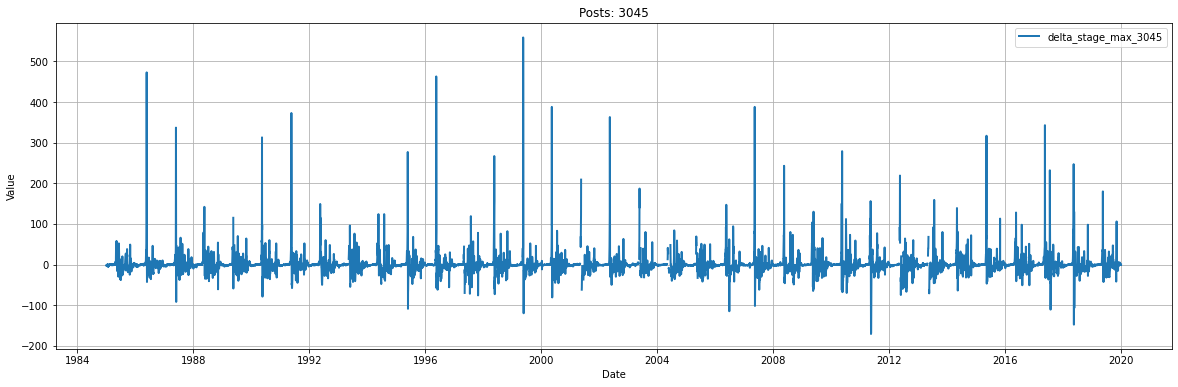

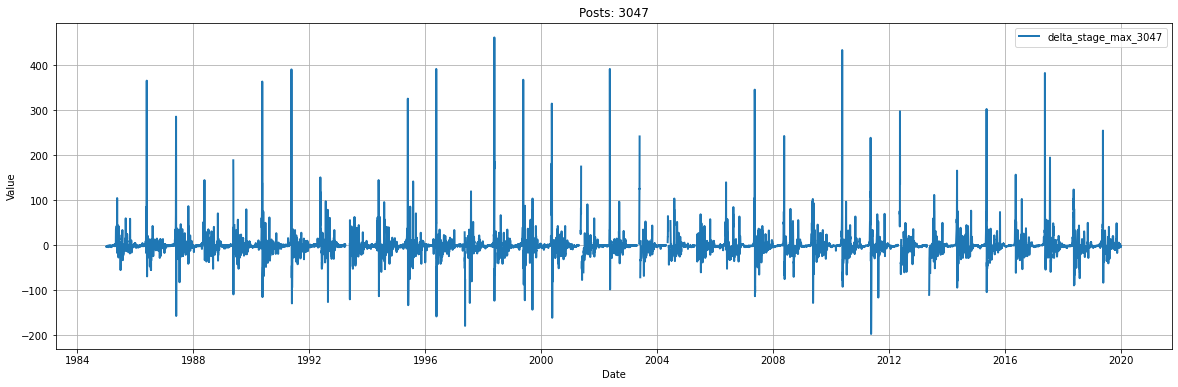

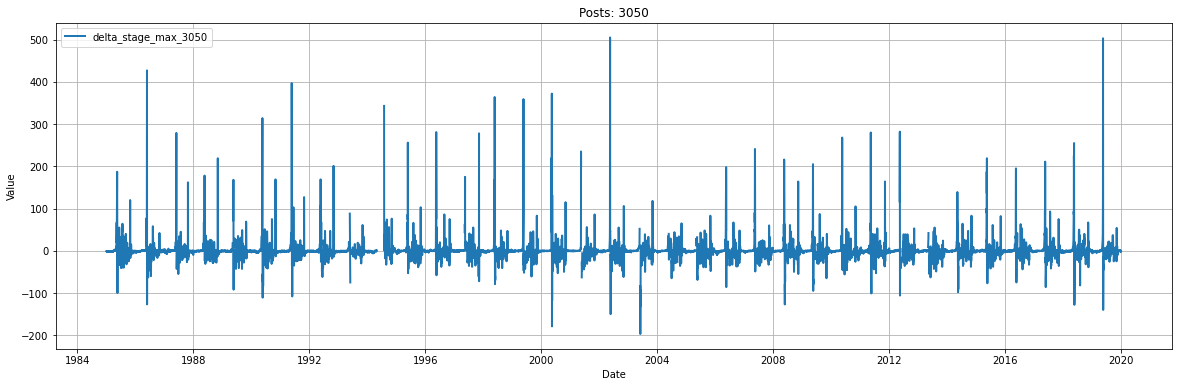

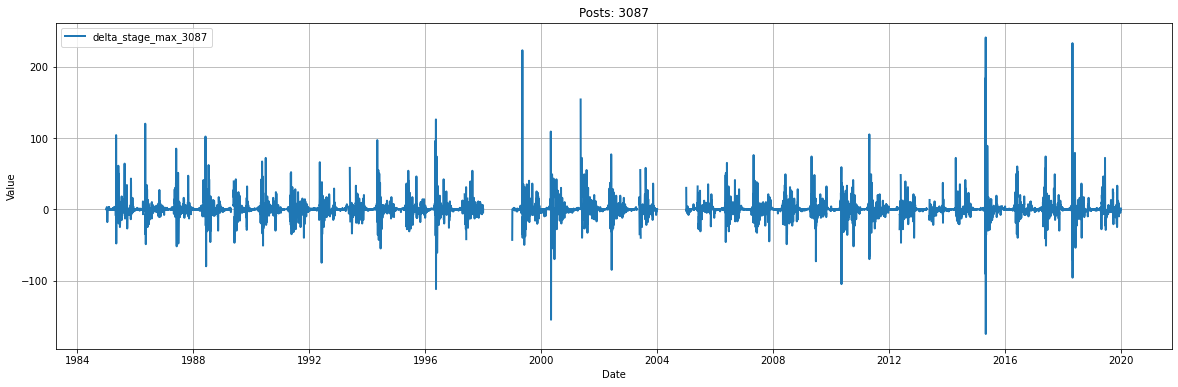

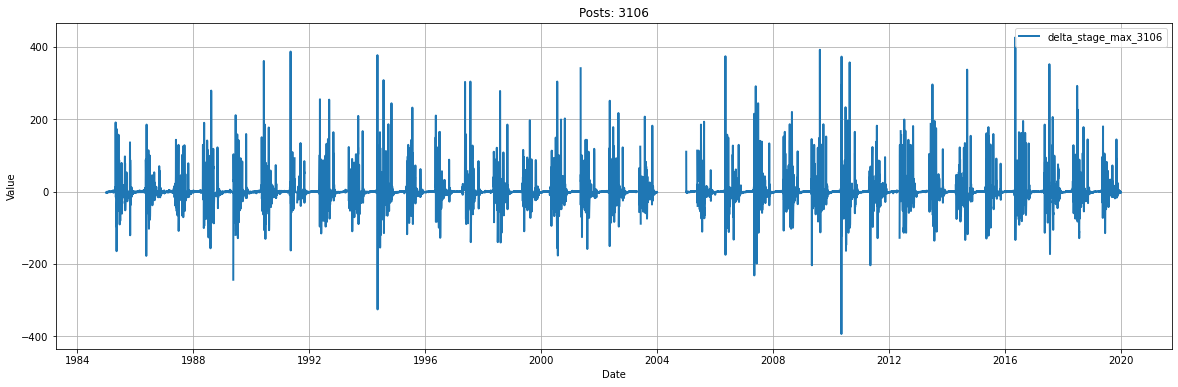

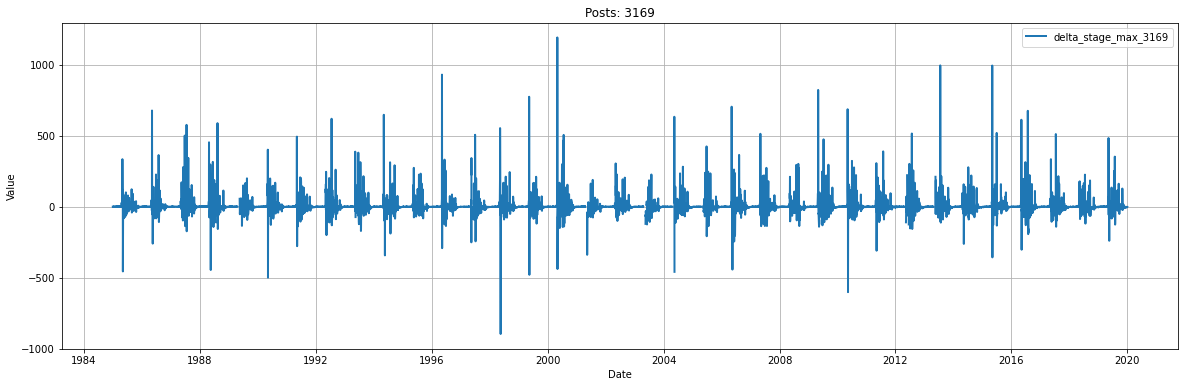

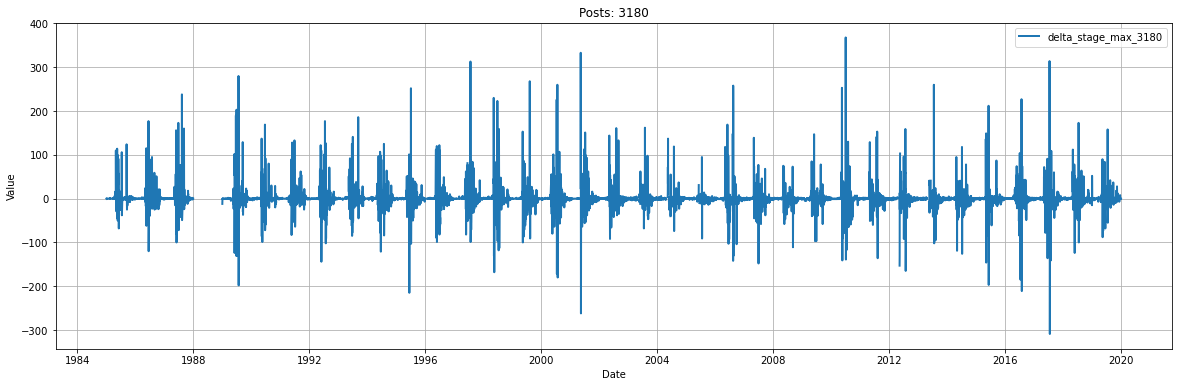

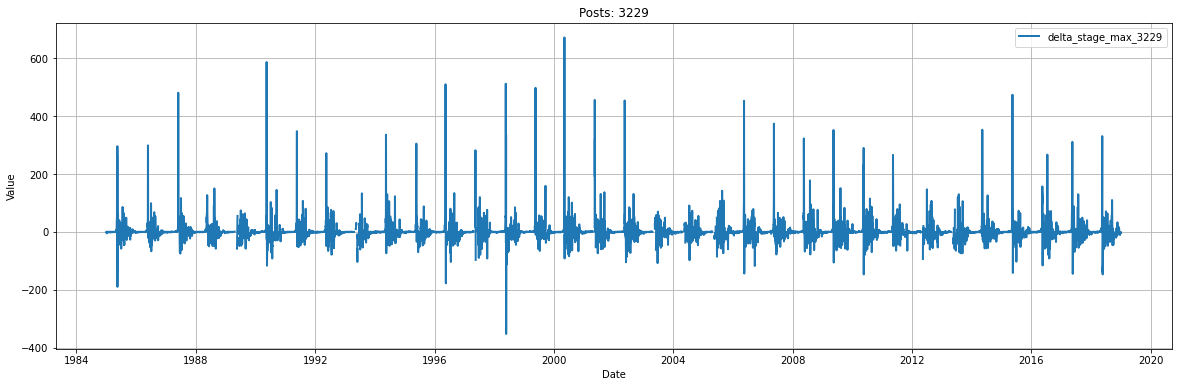

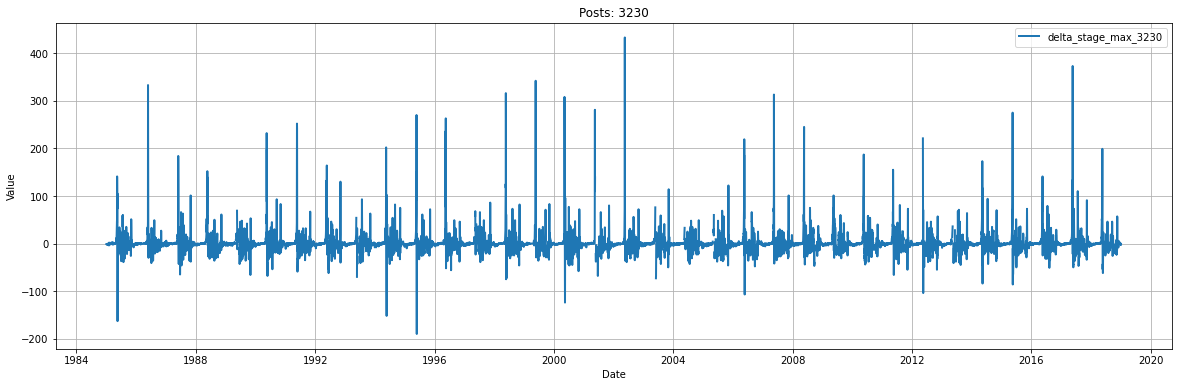

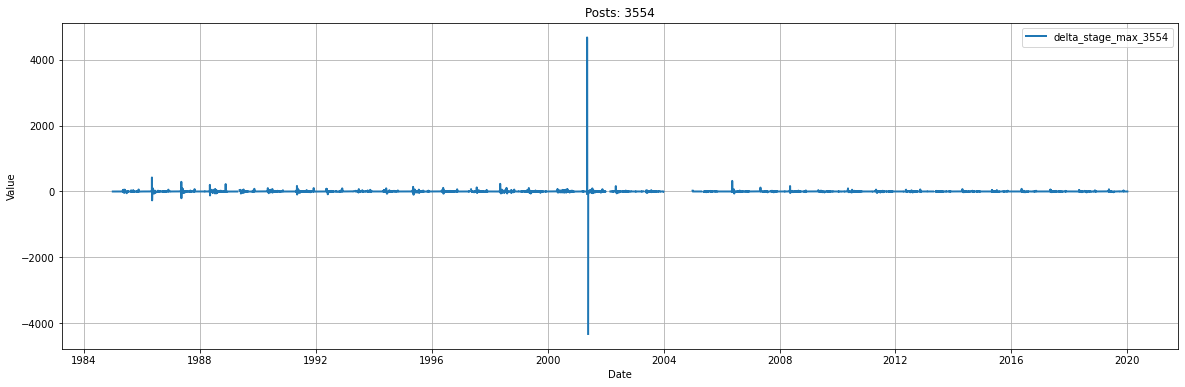

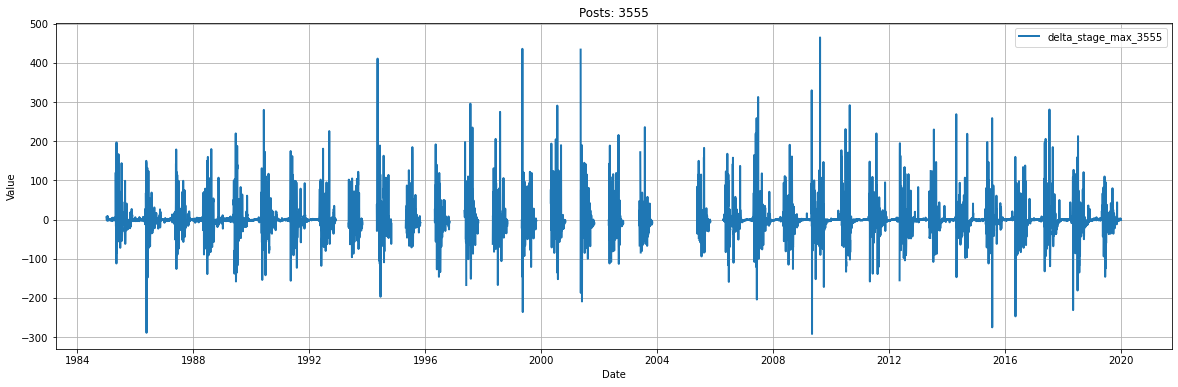

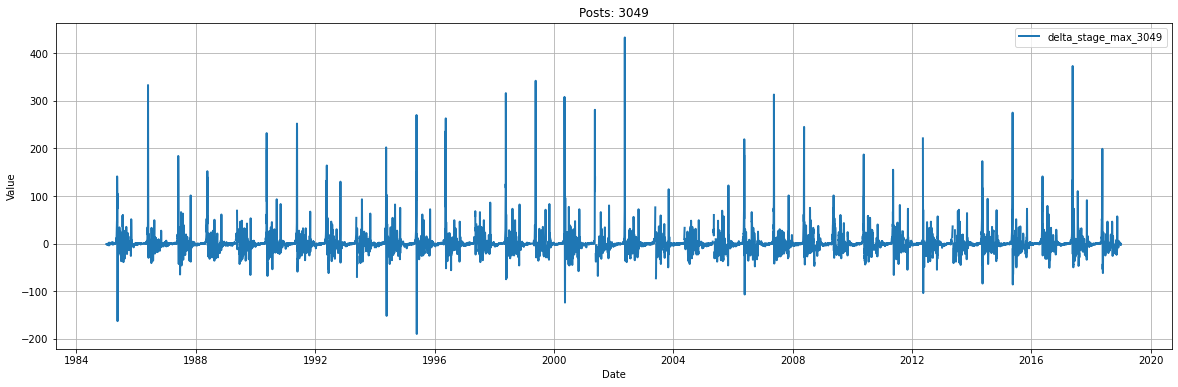

In [621]:
for station in train_hist.station_id.unique():
    try:
        plot_delta_stage_max(train_hist, [station], '1985-01-01', '2019-12-31')
    except:
        print(station)

По целевым постам пропуски были только для 3019 - Киренск

 Посмотрим более внимательно на один из целевых постов 3030

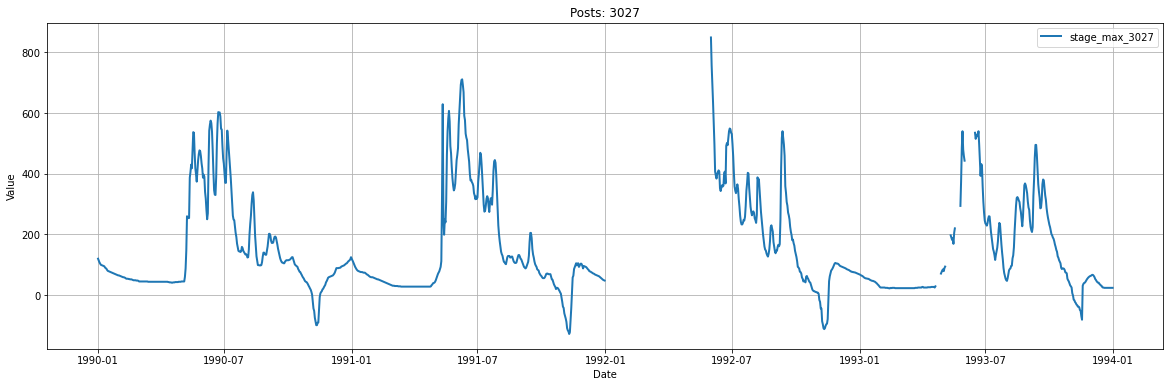

In [541]:
plot_stage(train_hist, [3027], '1990-01-01', '1993-12-31')

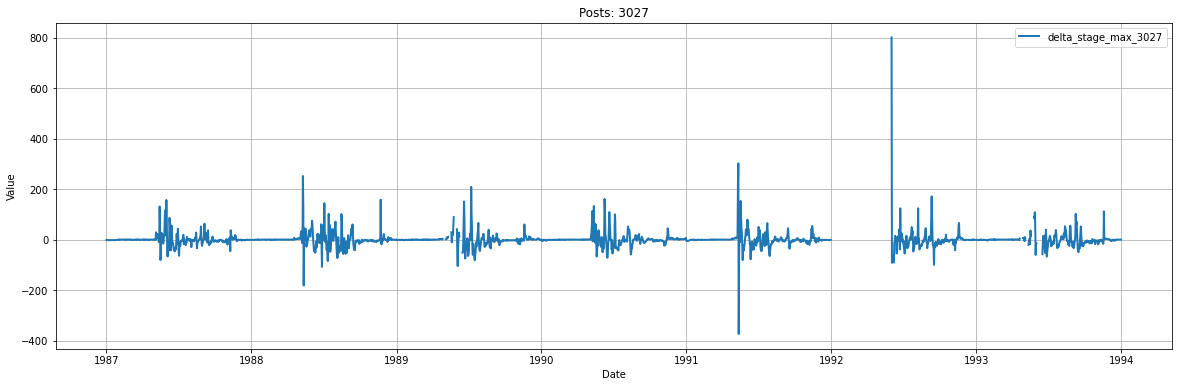

In [542]:
plot_delta_stage_max(train_hist, [3027], '1987-01-01', '1993-12-31')

# Граф гидропостов

In [543]:
river_names = []

for i in range(hydro_coord.shape[0]):
    river_names.append(hydro_coord.name.iloc[i].split(' ')[-1].split('.')[-1])
    
hydro_coord['river_name'] = river_names

In [544]:
hydro_coord = pd.concat([hydro_coord, 
                         pd.DataFrame({'station_id':3049, 'name':'БАТАМАЙ (ГП ПРИ БАТАМАЙ М) - Р.АЛДАН', 
                                       'lat':63.516667, 'lon':129.483333, 'distance_from_source':3004.0, 
                                       'drainage_area':729000, 'z_null':66.48, 'river_name':'ЛЕНА'}, index=[25])])

In [545]:
temp_3230 = train_hist[train_hist.station_id == 3230].reset_index(drop=True).copy()
temp_3230['station_id'] = 3049
train_hist = pd.concat([train_hist, temp_3230])

In [546]:
target_posts = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3049, 3050]

In [547]:
inflows = {
    3019: [3087],
    3027: [3087, 3554, 3555, 3106],
    3028: [3087, 3554, 3555, 3106], 
    3029: [3087, 3554, 3555, 3106], 
    3030: [3087, 3554, 3555, 3106], 
    3035: [3087, 3554, 3555, 3106], 
    3041: [3087, 3554, 3555, 3106, 3180, 3169], 
    3045: [3087, 3554, 3555, 3106, 3180, 3169], 
    3049: [3087, 3554, 3555, 3106, 3180, 3169, 3229],
    3050: [3087, 3554, 3555, 3106, 3180, 3169, 3229]
}

In [548]:
lena_posts = (hydro_coord[hydro_coord.river_name == 'ЛЕНА'].sort_values('distance_from_source').station_id.values)
lena_flows = {}

for post in target_posts:
    lena_flows[post] = []
    for x in lena_posts[lena_posts < post]:
        lena_flows[post].append(x)

# Соответственные уровни

$H_Н(t) = f\left( H_B(t-\tau_{i}) \right)$

$H_Н(t) = f\left( H_B(t-\tau_{i}) + \sum_{i=2}^{i=n}{p_i H_П(t-\tau_{i})} \right)$

> $H_Н(t)$ - уровень воды в нижнем створе в момент времени $t$

> $H_B(t-\tau_{i})$ - уровень воды в верхнем створе в момент времени $t-\tau_{i}$

> $H_П(t-\tau_{i})$ - уровень воды в верхнем створе притоков в момент времени $t-\tau_{i}$

> $p_i$ - коэффициент водности притоков

Однако, коэффициентом мы можем пренебречь в виду того, что модель сама подберет этот коэффициент.

Если же паводок на притоке запаздывает, то время добегания увеличивается. Наличие интерференции затрудняет возможность определения времени добегания.Поэтому на практике определение времени добегания производится по средней скорости движения паводков на бесприточных или слабоприточных участках.

> Расстояние между гидропостами находится путь поэтапного сложения расстояний между соседними гидропостами.

> Далее это расстояние делится на среднюю скорость движения паводков.

> Расстояние делится на скорость, получается время добегания

> Берем уровень воды на <время добегания> дней назад. Можно брать $\pm1 день$, чтобы наверняка попасть.

Буду брать скорость 6 км/ч, и делать $\pm1 день$

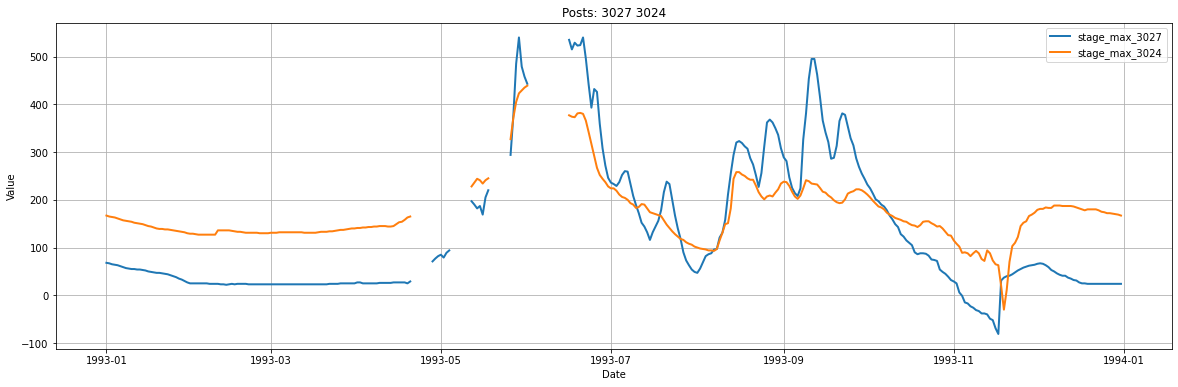

In [549]:
plot_stage(train_hist, [3027, 3024], '1993-01-01', '1993-12-31')

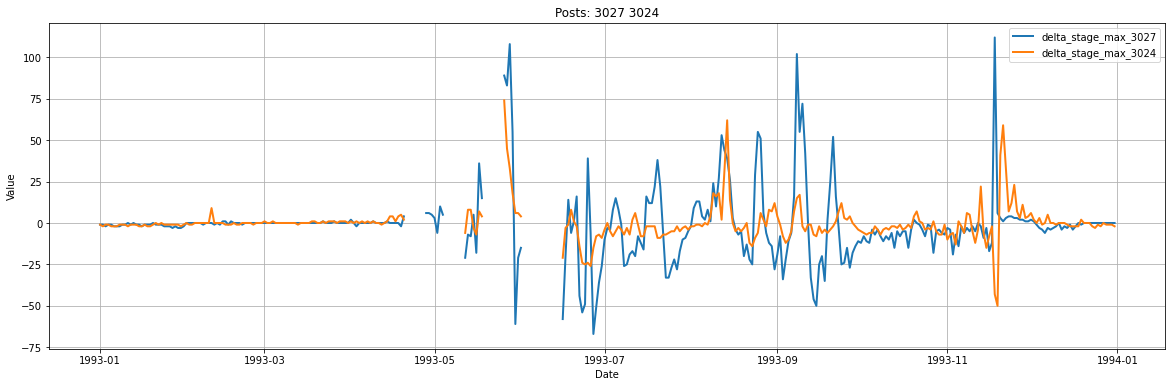

In [550]:
plot_delta_stage_max(train_hist, [3027, 3024], '1993-01-01', '1993-12-31')

In [551]:
# inflows - придется находить расстояние между гидропостами
# lena_flows - брать по distance_from_source

In [552]:
lena_running_times = {}

for post in lena_flows:
    dist_1 = hydro_coord[hydro_coord.station_id == post].distance_from_source.iloc[-1]
    lena_running_times[post] = {}
    for post_in in lena_flows[post]:
        dist_2 = hydro_coord[hydro_coord.station_id == post_in].distance_from_source.iloc[-1]
        lena_running_times[post][post_in] = int(round((dist_1 - dist_2) / (6*24)))

In [553]:
def distance_btw_posts(post_1, post_2, hydro_coord=hydro_coord):
    # (lat, lon)
    lat_1, lon_1 = hydro_coord[hydro_coord.station_id == post_1].lat.iloc[-1], hydro_coord[hydro_coord.station_id == post_1].lon.iloc[-1]
    lat_2, lon_2 = hydro_coord[hydro_coord.station_id == post_2].lat.iloc[-1], hydro_coord[hydro_coord.station_id == post_2].lon.iloc[-1]
    # коэффициент для учета извилистости реки
    return 1.2 * haversine((lat_1, lon_1), (lat_2, lon_2))

inflows_running_times = {}

for post in inflows:
    inflows_running_times[post] = {}
    for post_in in inflows[post]:
        inflows_running_times[post][post_in] = int(round(distance_btw_posts(post, post_in) / (6*24)))

In [554]:
inflows_running_times

{3019: {3087: 0},
 3027: {3087: 3, 3554: 0, 3555: 1, 3106: 2},
 3028: {3087: 3, 3554: 0, 3555: 1, 3106: 2},
 3029: {3087: 3, 3554: 1, 3555: 1, 3106: 2},
 3030: {3087: 4, 3554: 2, 3555: 2, 3106: 3},
 3035: {3087: 6, 3554: 4, 3555: 4, 3106: 4},
 3041: {3087: 10, 3554: 8, 3555: 8, 3106: 8, 3180: 4, 3169: 4},
 3045: {3087: 11, 3554: 8, 3555: 8, 3106: 8, 3180: 5, 3169: 5},
 3049: {3087: 11, 3554: 9, 3555: 9, 3106: 9, 3180: 5, 3169: 5, 3229: 1},
 3050: {3087: 10, 3554: 8, 3555: 8, 3106: 8, 3180: 5, 3169: 5, 3229: 2}}

In [555]:
def shift_stage(data, post, run_time):
    df = pd.DataFrame()
    if run_time-1 >= 0:
        df[-1] = data[data.station_id == post].delta_stage_max.shift(run_time-1)
    df[0] = data[data.station_id == post].delta_stage_max.shift(run_time)
    df[1] = data[data.station_id == post].delta_stage_max.shift(run_time+1)
    return df.reset_index(drop=True)

In [556]:
def previous_delta_stage_max(data, running_times, t_post, time=0):
    df = pd.DataFrame()
    df['date'] = data.sort_values('date').date.unique()
    for post in running_times[t_post]:
        df_temp = shift_stage(data, post, running_times[t_post][post]+time)
        if -1 in df_temp.columns:
            for i in range(-1, 2, 1):
                df['delta_stage_max_{}_{}'.format(post, running_times[t_post][post]+i)] = df_temp[i].values
        else:
            for i in range(0, 2, 1):
                df['delta_stage_max_{}_{}'.format(post, running_times[t_post][post]+i)] = df_temp[i].values
    return df

In [557]:
previous_delta_stage_max(train_hist, lena_running_times, 3027)

date  delta_stage_max_3019_2  delta_stage_max_3019_3  \
0     1985-01-01                     NaN                     NaN   
1     1985-01-02                     NaN                     NaN   
2     1985-01-03                     NaN                     NaN   
3     1985-01-04                     0.0                     NaN   
4     1985-01-05                     0.0                     0.0   
...          ...                     ...                     ...   
12778 2019-12-27                     0.0                     2.0   
12779 2019-12-28                     0.0                     0.0   
12780 2019-12-29                     0.0                     0.0   
12781 2019-12-30                     0.0                     0.0   
12782 2019-12-31                     0.0                     0.0   

       delta_stage_max_3019_4  delta_stage_max_3021_2  delta_stage_max_3021_3  \
0                         NaN                     NaN                     NaN   
1                         NaN                     NaN                     NaN   
2                         NaN                     NaN                     NaN   
3                         NaN                     0.0                     NaN   
4                         NaN                    -1.0                     0.0   
...                       ...                     ...                     ...   
12778                     1.0                     3.0                     1.0   
12779                     2.0                     2.0                     3.0   
12780                     0.0                     1.0                     2.0   
12781                     0.0                     0.0                     1.0   
12782                     0.0                     1.0                     0.0   

       delta_stage_max_3021_4  delta_stage_max_3024_0  delta_stage_max_3024_1  \
0                         NaN                     NaN                     NaN   
1                         NaN                     0.0                     NaN   
2                         NaN                     0.0                     0.0   
3                         NaN                     0.0                     0.0   
4                         NaN                     0.0                     0.0   
...                       ...                     ...                     ...   
12778                     2.0                    -1.0                    -1.0   
12779                     1.0                    -2.0                    -1.0   
12780                     3.0                     0.0                    -2.0   
12781                     2.0                    -2.0                     0.0   
12782                     1.0                     0.0                    -2.0   

       delta_stage_max_3024_2  
0                         NaN  
1                         NaN  
2                         NaN  
3                         0.0  
4                         0.0  
...                       ...  
12778                     0.0  
12779                    -1.0  
12780                    -1.0  
12781                    -2.0  
12782                     0.0  

[12783 rows x 10 columns]

# Сборка датасета

In [558]:
test_dates = [pd.to_datetime(x) for x in test.date.sort_values().unique()]
test_end_dates = [pd.to_datetime(x) for x in test.groupby('year').date.max().values]
test_start_dates = [pd.to_datetime(x) for x in test.groupby('year').date.min().values]

In [559]:
for i in range(len(test_end_dates)):
    print(test_start_dates[i].date(), ' --- ', test_end_dates[i].date())

1989-04-28  ---  1989-06-15
1993-04-21  ---  1993-06-08
1997-04-21  ---  1997-06-08
2001-04-21  ---  2001-06-08
2003-04-28  ---  2003-06-15
2004-04-21  ---  2004-06-08
2005-04-28  ---  2005-06-15
2012-04-21  ---  2012-06-08
2013-04-28  ---  2013-06-15


In [560]:
def mean_moving_average(df, n):
    res = (df['delta_stage_max'].rolling(int(n/2)).mean() + df['delta_stage_max'].iloc[::-1].rolling(int(n/2)).mean().iloc[::-1]) / 2
    res_df = df.copy()
    res_df['delta_stage_max_mean_roll_{}'.format(n)] = res
    return res_df[['day', 'month', 'delta_stage_max_mean_roll_{}'.format(n)]]

def min_moving_average(df, n):
    res = (df['delta_stage_max'].rolling(int(n/2)).min() + df['delta_stage_max'].iloc[::-1].rolling(int(n/2)).min().iloc[::-1]) / 2
    res_df = df.copy()
    res_df['delta_stage_max_min_roll_{}'.format(n)] = res
    return res_df[['day', 'month', 'delta_stage_max_min_roll_{}'.format(n)]]

def max_moving_average(df, n):
    res = (df['delta_stage_max'].rolling(int(n/2)).max() + df['delta_stage_max'].iloc[::-1].rolling(int(n/2)).max().iloc[::-1]) / 2
    res_df = df.copy()
    res_df['delta_stage_max_max_roll_{}'.format(n)] = res
    return res_df[['day', 'month', 'delta_stage_max_max_roll_{}'.format(n)]]

In [573]:
def process_dataset(df, post, start_test_date, end_test_date):
    
    temp = df.loc[(df.station_id == post), ['date', 'day', 'month', 'year', 'delta_stage_max', 'snow_height_aver', 'precipitation_corrected']].reset_index(drop=True).copy()
    temp = temp[(temp.date <= end_test_date)|(temp.date > '{}-12-31'.format(end_test_date.year))]
    
    # средние за +-n дней
    for i in range(7, 15, 7):
        temp = pd.merge(temp, 
                        mean_moving_average(temp.groupby(['month', 'day']).mean().reset_index(), i), 
                        on=['month', 'day'], how='left')
    
    for i in range(7, 15, 7):
        temp = pd.merge(temp, 
                        min_moving_average(temp.groupby(['month', 'day']).min().reset_index(), i), 
                        on=['month', 'day'], how='left')
        
    for i in range(7, 15, 7):
        temp = pd.merge(temp, 
                        max_moving_average(temp.groupby(['month', 'day']).max().reset_index(), i), 
                        on=['month', 'day'], how='left')
    
    # shift
    for i in range(1, 15):
        temp['delta_stage_max_{}'.format(i)] = temp.delta_stage_max.shift(i)
    
    # min, max, mean по годам
    temp = pd.merge(temp, 
                    temp[['month', 'day', 'delta_stage_max']].groupby(['month', 'day']).mean().reset_index().rename(columns={'delta_stage_max': 'delta_stage_max_mean'}), 
                    on=['month', 'day'], how='left')

    temp = pd.merge(temp, 
                    temp[['month', 'day', 'delta_stage_max']].groupby(['month', 'day']).max().reset_index().rename(columns={'delta_stage_max': 'delta_stage_max_max'}), 
                    on=['month', 'day'], how='left')
    
    temp = pd.merge(temp, 
                    temp[['month', 'day', 'delta_stage_max']].groupby(['month', 'day']).min().reset_index().rename(columns={'delta_stage_max': 'delta_stage_max_min'}), 
                    on=['month', 'day'], how='left')

    # фичи по добеганию
    run_temp = df.copy()
    run_temp.loc[(run_temp.date >= end_test_date)&(run_temp.date <= '{}-12-31'.format(end_test_date.year)), 'delta_stage_max'] = np.nan
    temp = pd.merge(temp, previous_delta_stage_max(run_temp, lena_running_times, 3027), on='date', how='left')
    
    return temp

# Catboost на соответственных уровнях

In [287]:
train_crop = train_hist[(train_hist.month >= 4)&(train_hist.month < 7)].copy()

In [437]:
result = pd.DataFrame()

for post in target_posts:
    
    for i in range(len(test_start_dates)):
    
        test_year = test_start_dates[i].year
    
        pdf = process_dataset(train_crop, post, test_start_dates[i], test_end_dates[i])
        
        df_test = pdf[(pdf.date.isin(test_dates))&(pdf.year == test_year)].drop(['delta_stage_max', 'day', 'month', 'year'], axis=1)

        for column in pdf.columns[28:]:
            pdf[column].iloc[np.random.choice(pdf.shape[0], int(pdf.shape[0]*0.6))] = np.nan

        df_train = pdf[(pdf.delta_stage_max.notnull())&(pdf.year != test_year)].copy()
        
        X, y = df_train.drop(['date', 'delta_stage_max', 'day', 'month', 'year'], axis=1), df_train['delta_stage_max']
        
        preds = np.zeros((df_test.shape[0]))
        val_rmse = 0
        
        for train_index, test_index in KFold(n_splits=5).split(X):
            
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            
            model = CatBoostRegressor(iterations=1000,
                                      early_stopping_rounds=250,
                                      l2_leaf_reg=3,
                                      task_type='GPU')

#             X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

            model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
            
            val_rmse += mean_squared_error(y_val, model.predict(X_val), squared=False) / 5
            preds += model.predict(df_test.drop(['date'], axis=1)) / 5
        
        temp_res = pd.DataFrame()
        temp_res['date'] = df_test.date.values
        temp_res['station_id'] = post
        temp_res['delta_stage_max'] = preds
        result = pd.concat([result, temp_res])
        
        print('{} --- {}/9 --- rmse {}'.format(post, i+1, val_rmse, squared=False))

3019 --- 1/9 --- rmse 18.0393388909835
3019 --- 2/9 --- rmse 18.690822288832297
3019 --- 3/9 --- rmse 18.615873587922284
3019 --- 4/9 --- rmse 18.12758622744717
3019 --- 5/9 --- rmse 18.69045513740107
3019 --- 6/9 --- rmse 18.41279326567572
3019 --- 7/9 --- rmse 18.515613731575836
3019 --- 8/9 --- rmse 18.23908973791556
3019 --- 9/9 --- rmse 18.497847147842723
3027 --- 1/9 --- rmse 49.013760383892375
3027 --- 2/9 --- rmse 49.039374400236625
3027 --- 3/9 --- rmse 48.75888449286256
3027 --- 4/9 --- rmse 50.30134732256435
3027 --- 5/9 --- rmse 48.87519057419857
3027 --- 6/9 --- rmse 49.87852244222128
3027 --- 7/9 --- rmse 51.22857816493287
3027 --- 8/9 --- rmse 51.99301283988222
3027 --- 9/9 --- rmse 50.09910357732184
3028 --- 1/9 --- rmse 51.50074247260049
3028 --- 2/9 --- rmse 53.09878508659298
3028 --- 3/9 --- rmse 51.42729611545285
3028 --- 4/9 --- rmse 50.08428336968588
3028 --- 5/9 --- rmse 50.7946026806782
3028 --- 6/9 --- rmse 50.74971844222335
3028 --- 7/9 --- rmse 50.80121141491

In [438]:
result.to_csv('result_kfold.csv', index=False)

In [439]:
result_copy = result.copy()
result_copy.loc[result_copy.station_id == 3049, 'station_id'] = 3230
result_copy.station_id.unique()

array([3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3230, 3050],
      dtype=int64)

In [440]:
result.groupby('station_id').date.count()

station_id
3019    252
3027    252
3028    252
3029    252
3030    252
3035    252
3041    252
3045    252
3049    252
3050    252
Name: date, dtype: int64

In [441]:
test.groupby('station_id').date.count()

station_id
3019    224
3027    252
3028    245
3029    252
3030    252
3035    252
3041    252
3045    252
3050    252
3230    252
Name: date, dtype: int64

In [513]:
test = pd.merge(test.drop(['delta_stage_max'], axis=1), result_copy, on=['station_id', 'date'], how='left')

In [443]:
def plot_prediction(data, prediction, station, year):  
    df = pd.concat([data[(data.station_id == station)&(data.year == year)],
                    prediction[(prediction.station_id == station)&(prediction.year == year)]]).sort_values('date').reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(df.date, df.delta_stage_max, linewidth=2)
    ax.grid()
    plt.show()

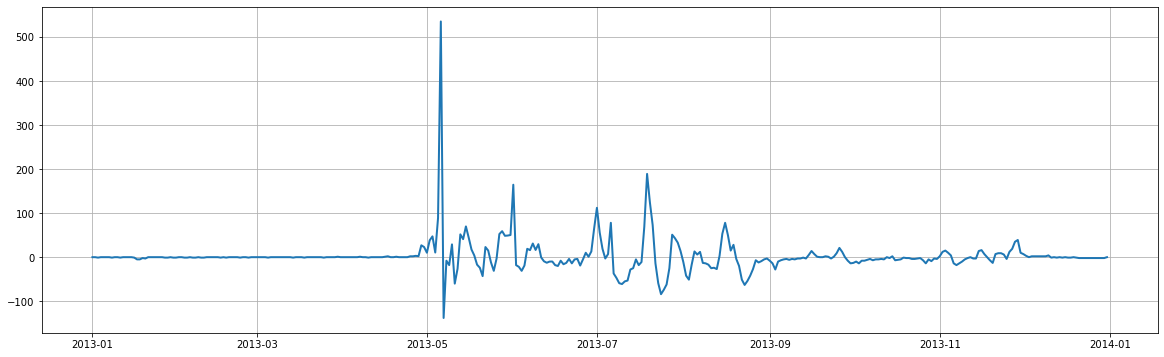

In [444]:
plot_prediction(train_hist[~train_hist.date.isin(test_dates)], test, 3027, 2013)

In [445]:
test.describe()

year   station_id        month          day        day_2  \
count  2485.000000  2485.000000  2485.000000  2485.000000  2485.000000   
mean   2001.890141  3053.859155     5.083300   138.428169    15.448290   
std       7.570682    59.824915     0.665989    16.096534     9.105099   
min    1989.000000  3019.000000     4.000000   111.000000     1.000000   
25%    1997.000000  3028.000000     5.000000   125.000000     7.000000   
50%    2003.000000  3035.000000     5.000000   139.000000    14.000000   
75%    2005.000000  3045.000000     6.000000   153.000000    24.000000   
max    2013.000000  3230.000000     6.000000   166.000000    31.000000   

       delta_stage_max  
count      2485.000000  
mean         -2.938503  
std          18.094413  
min         -79.829480  
25%         -12.762104  
50%          -5.949035  
75%           2.165766  
max         164.427516

In [446]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_7.csv', index=False)

# Среднее по окну 3 - RMSE 4,64

In [427]:
def mean_moving_average_test(station_id, date, n):
    
    day, month = pd.to_datetime(date).day, pd.to_datetime(date).month
    mean_val = []
    
    for year in range(1985, 2020):
        
        date_temp = pd.to_datetime('{}-{}-{}'.format(year, month, day))
        
        mean_val.append(train_hist[(train_hist.station_id == station_id)&
                               (train_hist.date >= (date_temp - datetime.timedelta(days=n)))&
                               (train_hist.date <= (date_temp + datetime.timedelta(days=n)))
                              ].delta_stage_max.mean())
    
    return np.nanmean(mean_val)

In [430]:
res = []
for i, val in tqdm(test.iterrows()):
    res.append(mean_moving_average_test(val['station_id'], val['date'], 3))

2485it [05:03,  8.18it/s]


In [433]:
test['delta_stage_max'] = res

In [436]:
test.describe()

year   station_id        month          day        day_2  \
count  2485.000000  2485.000000  2485.000000  2485.000000  2485.000000   
mean   2001.890141  3053.859155     5.083300   138.428169    15.448290   
std       7.570682    59.824915     0.665989    16.096534     9.105099   
min    1989.000000  3019.000000     4.000000   111.000000     1.000000   
25%    1997.000000  3028.000000     5.000000   125.000000     7.000000   
50%    2003.000000  3035.000000     5.000000   139.000000    14.000000   
75%    2005.000000  3045.000000     6.000000   153.000000    24.000000   
max    2013.000000  3230.000000     6.000000   166.000000    31.000000   

       delta_stage_max  
count      2485.000000  
mean         10.511116  
std          14.068600  
min         -10.933824  
25%           0.846154  
50%           6.673061  
75%          14.998848  
max          60.234454

In [434]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_roll_mean.csv', index=False)

# среднее по окну + кэт 4,57

In [463]:
test.delta_stage_max = 0.35 * np.array(test.delta_stage_max.values) + 0.65 * np.array(res)

In [464]:
test.describe()

year   station_id        month          day        day_2  \
count  2485.000000  2485.000000  2485.000000  2485.000000  2485.000000   
mean   2001.890141  3053.859155     5.083300   138.428169    15.448290   
std       7.570682    59.824915     0.665989    16.096534     9.105099   
min    1989.000000  3019.000000     4.000000   111.000000     1.000000   
25%    1997.000000  3028.000000     5.000000   125.000000     7.000000   
50%    2003.000000  3035.000000     5.000000   139.000000    14.000000   
75%    2005.000000  3045.000000     6.000000   153.000000    24.000000   
max    2013.000000  3230.000000     6.000000   166.000000    31.000000   

       delta_stage_max  
count      2485.000000  
mean          5.803749  
std          12.523281  
min         -25.282216  
25%          -2.707229  
50%           2.112612  
75%          11.925502  
max          78.074390

In [465]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_roll_mean_cat_9.csv', index=False)

# Аггрегация метеоданных

Пока что возьму только данные о накоплениях снега и осадках за месяц. Также полезные данные об изменении температур.

In [562]:
meteo_1day = meteo_1day_hist[['station_id', 'date', 'snow_height_aver']]

meteo_1month = meteo_1month_hist[['station_id', 'date', 'year', 'month', 'precipitation_corrected']]

In [563]:
snow_df = pd.DataFrame()

for i in range(1984, 2020):
    temp_snow_df = meteo_1day[(meteo_1day.date >= '1984-07-01')&(meteo_1day.date < '1985-07-01')].groupby('station_id').snow_height_aver.max().reset_index()
    temp_snow_df['year'] = i+1
    snow_df = pd.concat([snow_df, temp_snow_df])

In [564]:
tree = BallTree(meteo_coord[['lat', 'lon']].values, leaf_size=2)
distance_nearest, idx_nearest = tree.query(hydro_coord[['lat', 'lon']].values, k=3)

In [565]:
target_posts_ = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3050, 3230]

hydropercip = pd.DataFrame()
hydrosnow = pd.DataFrame()

for post in target_posts_:
    
    idx = hydro_coord[hydro_coord.station_id == post].index[-1]
    temp = meteo_1month[meteo_1month.station_id.isin(meteo_coord.iloc[idx_nearest[idx]].station_id.values)].groupby('date').precipitation_corrected.mean().reset_index().copy()
    temp['station_id'] = post
    hydropercip = pd.concat([hydropercip, temp])
    
    temp = snow_df[snow_df.station_id.isin(meteo_coord.iloc[idx_nearest[0]].station_id.values)].groupby('year').snow_height_aver.mean().reset_index().copy()
    temp['station_id'] = post
    hydrosnow = pd.concat([hydrosnow, temp])

In [566]:
hydropercip['year'] = hydropercip.date.apply(lambda x: x.year)
hydropercip['month'] = hydropercip.date.apply(lambda x: x.month)
hydropercip = hydropercip.drop(['date'], axis=1)

In [567]:
train_hist = pd.merge(train_hist, hydrosnow, on=['station_id', 'year'], how='left')

In [568]:
train_hist = pd.merge(train_hist, hydropercip, on=['station_id', 'year', 'month'], how='left')

# Новое среднее по окну и сумма всего 4,55

In [497]:
def mean_moving_average_btw(station_id, date, n):
    
    day, month, year = pd.to_datetime(date).day, pd.to_datetime(date).month, pd.to_datetime(date).year
    mean_val = []
    
    for y in range(year-2, year+2):
        
        date_temp = pd.to_datetime('{}-{}-{}'.format(y, month, day))
        
        mean_val.append(train_hist[(train_hist.station_id == station_id)&
                               (train_hist.date >= (date_temp - datetime.timedelta(days=n)))&
                               (train_hist.date <= (date_temp + datetime.timedelta(days=n)))
                              ].delta_stage_max.mean())
    
    return np.nanmean(mean_val)

In [506]:
res_2 = []
for i, val in tqdm(test.iterrows()):
    res_2.append(mean_moving_average_btw(val['station_id'], val['date'], 5))

2485it [00:37, 67.11it/s]


In [510]:
test['delta_stage_max'] = res_2

In [511]:
test.describe()

year   station_id        month          day  delta_stage_max
count  2485.000000  2485.000000  2485.000000  2485.000000      2485.000000
mean   2001.890141  3053.859155     5.083300   138.428169        10.043966
std       7.570682    59.824915     0.665989    16.096534        20.252167
min    1989.000000  3019.000000     4.000000   111.000000       -44.965909
25%    1997.000000  3028.000000     5.000000   125.000000        -1.324242
50%    2003.000000  3035.000000     5.000000   139.000000         4.204545
75%    2005.000000  3045.000000     6.000000   153.000000        19.164773
max    2013.000000  3230.000000     6.000000   166.000000       148.653409

In [517]:
test.delta_stage_max = 0.3 * np.array(test.delta_stage_max.values) + 0.2 * np.array(res_2) + 0.5 * np.array(res)

In [518]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_roll_roll_cat.csv', index=False)

# Cat на новых фичах

In [569]:
train_crop = train_hist[(train_hist.month >= 4)&(train_hist.month < 7)].copy()

In [582]:
result_2 = pd.DataFrame()

for post in target_posts:
    
    for i in range(len(test_start_dates)):
    
        test_year = test_start_dates[i].year
    
        pdf = process_dataset(train_crop, post, test_start_dates[i], test_end_dates[i])
        
        df_test = pdf[(pdf.date.isin(test_dates))&(pdf.year == test_year)].drop(['delta_stage_max', 'year'], axis=1)

        for column in pdf.columns[30:]:
            pdf[column].iloc[np.random.choice(pdf.shape[0], int(pdf.shape[0]*0.7))] = np.nan

        df_train = pdf[(pdf.delta_stage_max.notnull())&(pdf.year != test_year)].copy()
        
        X, y = df_train.drop(['date', 'delta_stage_max', 'year'], axis=1), df_train['delta_stage_max']
        
        preds = np.zeros((df_test.shape[0]))
        val_rmse = 0
        
        for train_index, test_index in KFold(n_splits=5).split(X):
            
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            
            model = CatBoostRegressor(iterations=1000,
                                      early_stopping_rounds=250,
                                      l2_leaf_reg=3,
                                      task_type='GPU')

#             X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

            model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
            
            val_rmse += mean_squared_error(y_val, model.predict(X_val), squared=False) / 5
            preds += model.predict(df_test.drop(['date'], axis=1)) / 5
        
        temp_res = pd.DataFrame()
        temp_res['date'] = df_test.date.values
        temp_res['station_id'] = post
        temp_res['delta_stage_max'] = preds
        result_2 = pd.concat([result_2, temp_res])
        
        print('{} --- {}/9 --- rmse {}'.format(post, i+1, val_rmse, squared=False))

3019 --- 1/9 --- rmse 18.722957471750107
3019 --- 2/9 --- rmse 18.416528809669032
3019 --- 3/9 --- rmse 18.609105274073308
3019 --- 4/9 --- rmse 17.678250266138324
3019 --- 5/9 --- rmse 18.760680370206533
3019 --- 6/9 --- rmse 18.209032377947185
3019 --- 7/9 --- rmse 18.782754124782784
3019 --- 8/9 --- rmse 18.302197915956533
3019 --- 9/9 --- rmse 17.908344909679272
3027 --- 1/9 --- rmse 50.78026596419511
3027 --- 2/9 --- rmse 51.077090212522975
3027 --- 3/9 --- rmse 48.708932014131506
3027 --- 4/9 --- rmse 49.45252004591151
3027 --- 5/9 --- rmse 53.17872422726658
3027 --- 6/9 --- rmse 50.89565121561413
3027 --- 7/9 --- rmse 54.01346562662356
3027 --- 8/9 --- rmse 53.752725440212885
3027 --- 9/9 --- rmse 53.58573229569167
3028 --- 1/9 --- rmse 52.18122598023774
3028 --- 2/9 --- rmse 52.79758669222028
3028 --- 3/9 --- rmse 50.146808035119626
3028 --- 4/9 --- rmse 50.54493568093938
3028 --- 5/9 --- rmse 53.721570448417786
3028 --- 6/9 --- rmse 51.10518117165465
3028 --- 7/9 --- rmse 51.6

In [586]:
result_2

date  station_id  delta_stage_max
0  1989-04-28        3019         2.961352
1  1989-04-29        3019         3.948346
2  1989-04-30        3019        11.435488
3  1989-05-01        3019         2.178467
4  1989-05-02        3019         5.311860
..        ...         ...              ...
23 2013-06-11        3050        -4.561985
24 2013-06-12        3050        -4.004209
25 2013-06-13        3050        -6.126714
26 2013-06-14        3050        -4.352096
27 2013-06-15        3050        -4.193605

[2520 rows x 3 columns]

In [587]:
result_copy_2 = result_2.copy()
result_copy_2.loc[result_copy_2.station_id == 3049, 'station_id'] = 3230
result_copy_2.station_id.unique()

array([3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3230, 3050],
      dtype=int64)

In [595]:
test = pd.merge(test.drop(['delta_stage_max'], axis=1), result_copy_2, on=['station_id', 'date'], how='left')

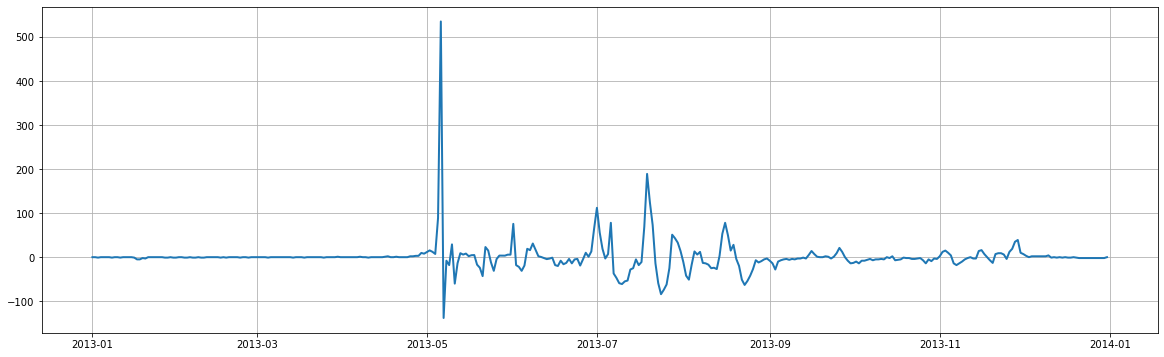

In [596]:
plot_prediction(train_hist[~train_hist.date.isin(test_dates)], test, 3027, 2013)

In [597]:
test.describe()

year   station_id        month          day  delta_stage_max
count  2485.000000  2485.000000  2485.000000  2485.000000      2485.000000
mean   2001.890141  3053.859155     5.083300   138.428169        -2.612238
std       7.570682    59.824915     0.665989    16.096534        17.440291
min    1989.000000  3019.000000     4.000000   111.000000       -82.379678
25%    1997.000000  3028.000000     5.000000   125.000000       -12.055293
50%    2003.000000  3035.000000     5.000000   139.000000        -5.458441
75%    2005.000000  3045.000000     6.000000   153.000000         2.450410
max    2013.000000  3230.000000     6.000000   166.000000       147.358066

In [598]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_cat_10.csv', index=False)

In [599]:
test.delta_stage_max = 0.4 * np.array(test.delta_stage_max.values) + 0.6 * np.array(res)

In [600]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_cat_12.csv', index=False)

In [615]:
test_1 = pd.merge(test.drop(['delta_stage_max'], axis=1), result_copy, on=['station_id', 'date'], how='left')
test_2 = pd.merge(test.drop(['delta_stage_max'], axis=1), result_copy_2, on=['station_id', 'date'], how='left')

In [616]:
test_1.delta_stage_max = 0.3 * np.array(test_1.delta_stage_max.values) + 0.7 * np.array(res)
test_2.delta_stage_max = 0.35 * np.array(test_2.delta_stage_max.values) + 0.65 * np.array(res)

In [617]:
test.delta_stage_max = 0.7 * test_1.delta_stage_max + 0.3 * test_2.delta_stage_max

In [618]:
test.describe()

year   station_id        month          day  delta_stage_max
count  2485.000000  2485.000000  2485.000000  2485.000000      2485.000000
mean   2001.890141  3053.859155     5.083300   138.428169         6.308744
std       7.570682    59.824915     0.665989    16.096534        12.441677
min    1989.000000  3019.000000     4.000000   111.000000       -22.612826
25%    1997.000000  3028.000000     5.000000   125.000000        -2.116261
50%    2003.000000  3035.000000     5.000000   139.000000         2.723797
75%    2005.000000  3045.000000     6.000000   153.000000        12.344738
max    2013.000000  3230.000000     6.000000   166.000000        71.980353

In [619]:
test[['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max']].to_csv('submit_20.csv', index=False)